# Assignment 2 - Hybrid Learning in Neural Networks for Almond Classification

In [1]:
# general
import logging

# data
import numpy as np
import pandas as pd
import scipy.stats as scistats
from sklearn import preprocessing
from sklearn.model_selection import train_test_split, KFold

# nn
import tensorflow as tf; print(tf.__version__)
tf.config.run_functions_eagerly(True)
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import itertools
import mlflow
import random

# report
import matplotlib.pyplot as plt
import latextable
from texttable import Texttable


plt.rcParams['font.size'] = 13

2024-10-04 19:51:30.950663: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-10-04 19:51:31.041944: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-10-04 19:51:31.131758: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-04 19:51:31.207974: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-10-04 19:51:31.228206: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-10-04 19:51:31.377140: I tensorflow/core/platform/cpu_feature_gu

2.17.0


## Tasks

- Optimise and train NN to perform Almond Classification
- Preprocess Data
- Optimise NN's hyperparameters
- perform a comparative study between various gradient-based training algorithms
- develop a hybrid training algorithm that averages the gradient information across multiple training algorithms

## Data

### Columns


| Feature Name | Feature Description |
| --- | --- |
| Length (major axis) | Length of the almond in the image (based on number of pixels) |
| Width (minor axis) | Width of the almond in the image (based on number of pixels) |
| Thickness (depth) | Thickness of the almond in the image (based on number of pixels) |
| Area | The area of the Almond region detected in the image |
| Perimeter | Total length of the almond boundary |
| Roundness | Roundness of the almond: 4 * area / ( π * length ** 2) |
| Solidity | Area / area_hull |
| Compactness | perimeter**2 / (4 * π * area) |
| Aspect Ratio | Length / Width |
| Eccentricity | sqrt(1 - ( Width / Length ) **2 ) |
| Extent | Area / area_bbox(bounding box) |
| Convex hull(convex area, or area hull) | smallest convex set that contains bounding points |
| Type | Almond Type |

### Data Pre-Processing

Four types of data pre-processing looked at:
1. Drop all rows with nulls in them
    - df.shape() -> (0, 12)
2. Drop columns that have nulls
    - df.shape() -> (2803, 6)
3. Replace nulls with column means 
    - df.shape() -> (2803, 12)
4. Replace nulls based on a fitted distribution to the data.
    - df.shape() -> (2803, 12)

#### 0. Raw Data

#################### Count Nulls ####################
length_major_axis           857
width_minor_axis            942
thickness_depth            1004
area                          0
perimeter                     0
roundness                   857
solidity                      0
compactness                   0
aspect_ratio               1799
eccentricity               1799
extent                        0
convex_hull_convex_area       0
almond_type                   0
dtype: int64
#####################################################
#################### Count Types ####################
almond_type
SANORA     943
MAMRA      933
REGULAR    927
Name: count, dtype: int64


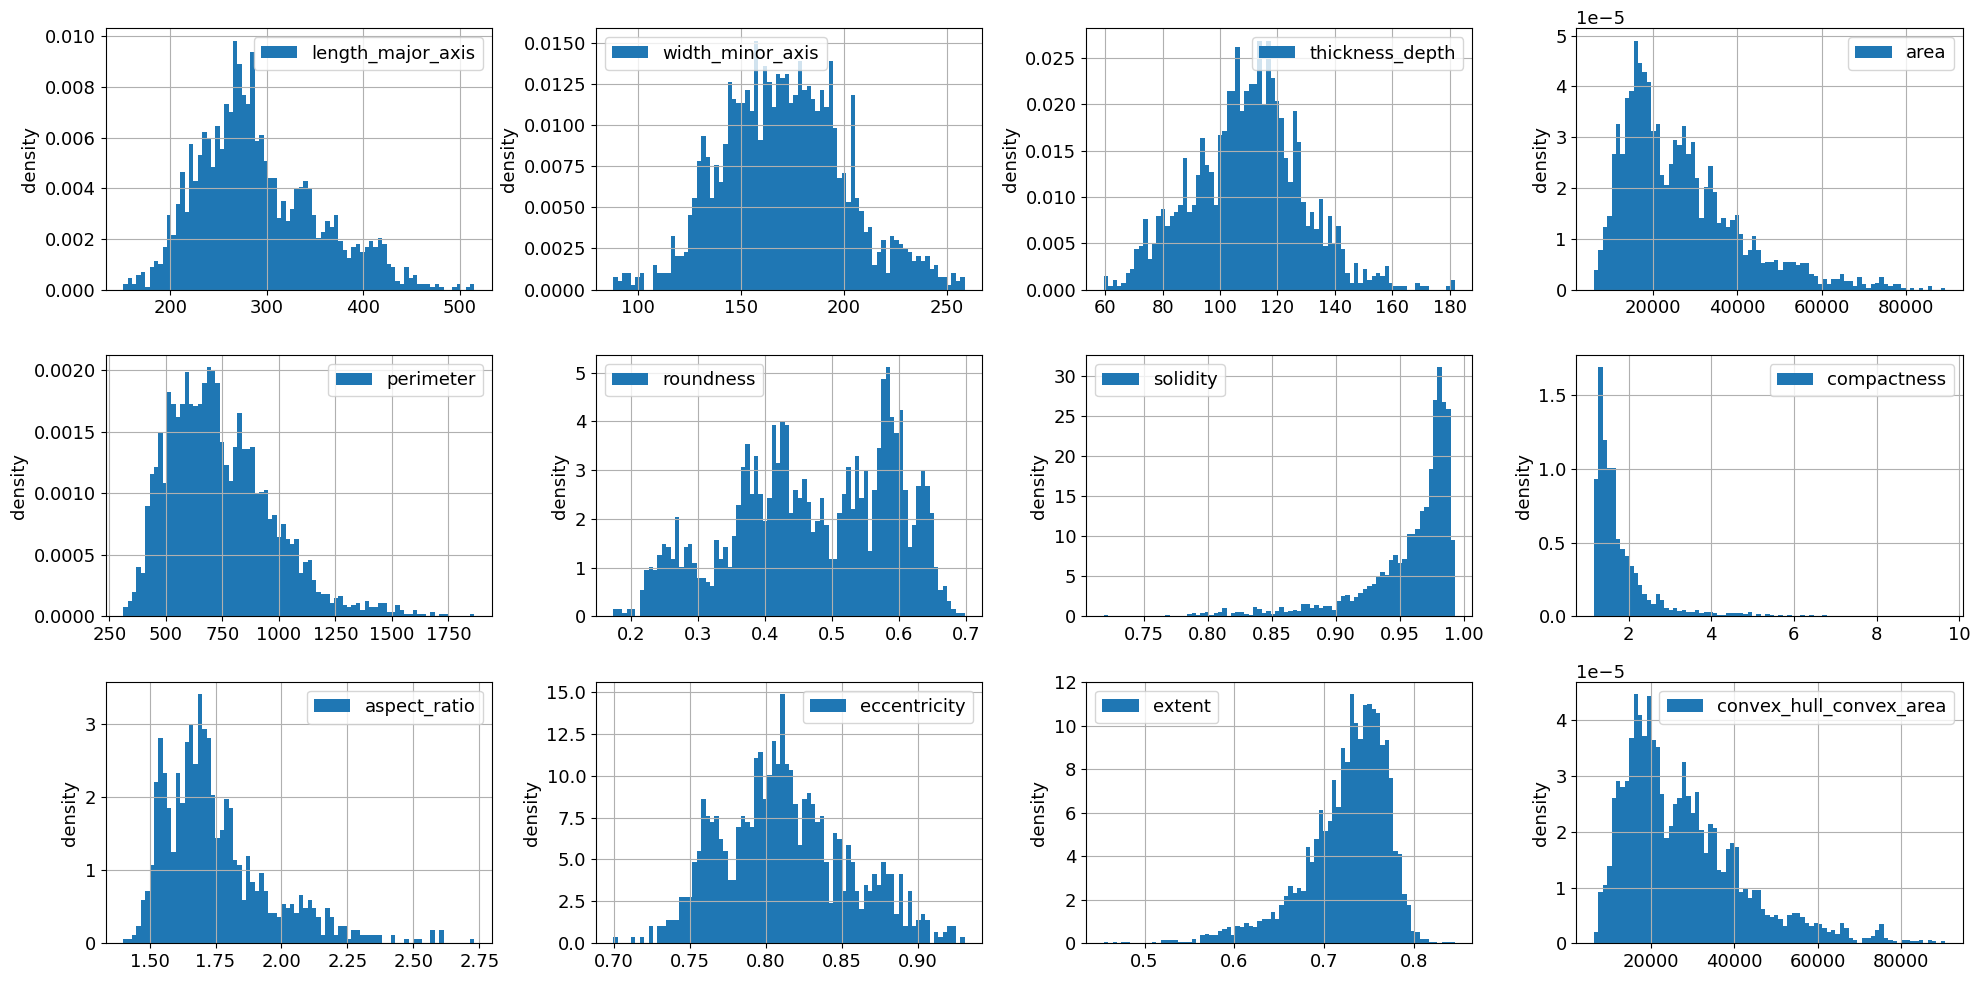

\begin{table}[!ht]
	\caption{Properties of each feature}
	\begin{center}
		\begin{tabular}{crrrrrrrr}
			Column Name & Non-Null Count & Mean & Minimum Value & Maximum Value & Standard Deviation & Variance & Skewness & Kurtosis \\
			\hline
			Length (major axis) & 1946.000 & 290.609 & 151.335 & 515.352 & 62.719 & 3933.727 & 0.644 & 0.083 \\
			Width (minor axis) & 1861.000 & 171.026 & 88.051 & 258.570 & 29.917 & 894.999 & 0.204 & -0.042 \\
			Thickness (depth) & 1799.000 & 109.705 & 59.494 & 181.845 & 18.941 & 358.746 & 0.133 & 0.269 \\
			Area & 2803.000 & 26511.117 & 6037.000 & 89282.000 & 13782.561 & 189958997.193 & 1.242 & 1.627 \\
			Perimeter & 2803.000 & 743.864 & 311.563 & 1864.947 & 230.632 & 53191.154 & 0.919 & 1.130 \\
			Roundness & 1946.000 & 0.470 & 0.174 & 0.697 & 0.119 & 0.014 & -0.310 & -0.882 \\
			Solidity & 2803.000 & 0.956 & 0.719 & 0.993 & 0.040 & 0.002 & -2.175 & 5.460 \\
			Compactness & 2803.000 & 1.825 & 1.164 & 9.660 & 0.794 & 0.631 & 3.218 & 14.887 \\
			Asp

In [2]:
data__df = pd.read_csv('data/Almond.csv')
data__df.pop("Unnamed: 0")
col_names__renaming = {
    'Length (major axis)': "length_major_axis",
    'Width (minor axis)': "width_minor_axis",
    'Thickness (depth)': "thickness_depth",
    'Area': "area",
    'Perimeter': "perimeter",
    'Roundness': "roundness",
    'Solidity': "solidity",
    'Compactness': "compactness",
    'Aspect Ratio': "aspect_ratio",
    'Eccentricity': "eccentricity",
    'Extent': "extent",
    'Convex hull(convex area)': "convex_hull_convex_area",
    'Type': "almond_type"
}
data__df = data__df.rename(columns=col_names__renaming)


print("#"*20, "Count Nulls", "#"*20)
print(data__df.isnull().sum())
print("#"*53)

print("#"*20, "Count Types", "#"*20)
print(data__df['almond_type'].value_counts())

# print("#"*20, "Col Details", "#"*20)
# print(data__df['length_major_axis'].describe())
# print("#"*53)
table_list = [
    ["Column Name", "Non-Null Count", "Mean", "Minimum Value", "Maximum Value", "Standard Deviation", "Variance", "Skewness", "Kurtosis"]
]

plt.figure(1, (20, 10), dpi=100)
idx = 0
for lab, col in col_names__renaming.items():

    if col != 'almond_type':
        idx += 1
        table_list.append(
            [
                lab,
                data__df[col].count(),
                data__df[col].mean(),
                data__df[col].min(),
                data__df[col].max(),
                data__df[col].std(),
                data__df[col].var(),
                data__df[col].skew(),
                data__df[col].kurtosis(),
            ]
        )

        plt.subplot(3, 4, idx)
        plt.hist(data__df[col], bins=80, density=True, label=col)
        plt.ylabel("density")
        plt.legend()
        plt.grid()

plt.tight_layout()
plt.savefig("report/assets/data__distributions__raw", dpi=200)
plt.show()

# Create Tables
table_1 = Texttable()
table_1.set_cols_align(["c"]+["r"]*8)
table_1.set_cols_valign(["m"]*9)
table_1.set_cols_dtype(['t']+['f']*8)
table_1.set_deco(Texttable.HEADER )
table_1.set_precision(3)
table_1.add_rows(
    table_list
)


# print(table_1.draw())
print(latextable.draw_latex(
    table_1,
    caption="Properties of each feature",
    label="tab:prop_of_features",
    position='!ht',
    caption_above=True
))


| **Column Name**          | **Non-Null Count** | **Mean**  | **Minimum Value** | **Maximum Value** | **Standard Deviation** | **Variance**  | **Skewness** | **Kurtosis** |
|:------------------------:|:------------------:|:---------:|:-----------------:|:-----------------:|:----------------------:|:-------------:|:------------:|:------------:|
| Length (major axis)      | 1946.000           | 290.609   | 151.335           | 515.352           | 62.719                 | 3933.727      | 0.644        | 0.083        |
| Width (minor axis)       | 1861.000           | 171.026   | 88.051            | 258.570           | 29.917                 | 894.999       | 0.204        | -0.042       |
| Thickness (depth)        | 1799.000           | 109.705   | 59.494            | 181.845           | 18.941                 | 358.746       | 0.133        | 0.269        |
| Area                     | 2803.000           | 26511.117 | 6037.000          | 89282.000         | 13782.561              | 189958997.193 | 1.242        | 1.627        |
| Perimeter                | 2803.000           | 743.864   | 311.563           | 1864.947          | 230.632                | 53191.154     | 0.919        | 1.130        |
| Roundness                | 1946.000           | 0.470     | 0.174             | 0.697             | 0.119                  | 0.014         | -0.310       | -0.882       |
| Solidity                 | 2803.000           | 0.956     | 0.719             | 0.993             | 0.040                  | 0.002         | -2.175       | 5.460        |
| Compactness              | 2803.000           | 1.825     | 1.164             | 9.660             | 0.794                  | 0.631         | 3.218        | 14.887       |
| Aspect Ratio             | 1004.000           | 1.753     | 1.400             | 2.731             | 0.207                  | 0.043         | 1.370        | 2.245        |
| Eccentricity             | 1004.000           | 0.813     | 0.700             | 0.931             | 0.041                  | 0.002         | 0.315        | -0.318       |
| Extent                   | 2803.000           | 0.725     | 0.455             | 0.846             | 0.047                  | 0.002         | -1.333       | 2.680        |
| Convex hull(convex area) | 2803.000           | 27696.218 | 6355.000          | 90642.500         | 14237.348              | 202702066.975 | 1.230        | 1.607        |


#### 1. Drop rows with nulls

In [3]:
df__dropped = data__df.dropna(inplace=False)
df__dropped.shape

(0, 13)

#### 2. Drop columns with Nulls

In [4]:
df__dropped__cols = data__df.dropna(axis='columns', inplace=False)
df__dropped__cols.shape

(2803, 7)

#### 3. Fill Nan with Mean of columns

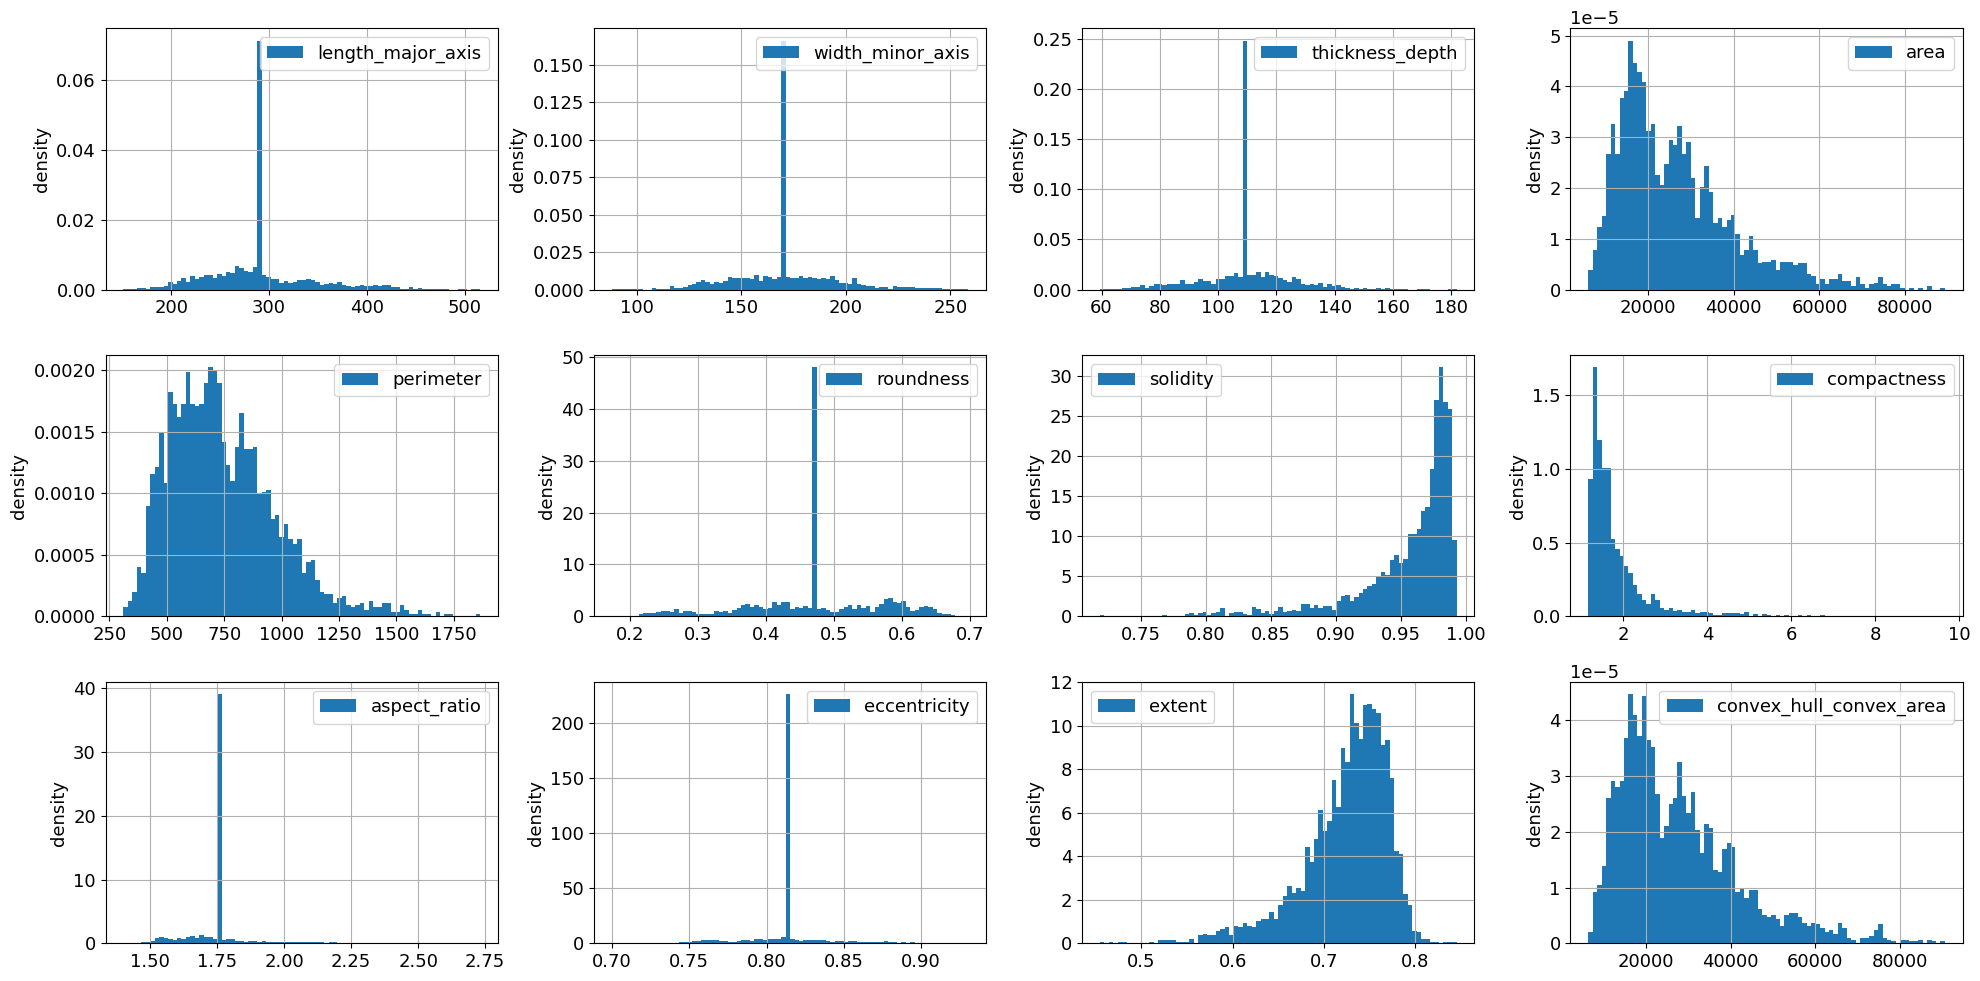

\begin{table}[!ht]
	\caption{Properties of each feature}
	\begin{center}
		\begin{tabular}{crrrrrrrr}
			Column Name & Non-Null Count & Mean & Minimum Value & Maximum Value & Standard Deviation & Variance & Skewness & Kurtosis \\
			\hline
			Length (major axis) & 2803.000 & 290.609 & 151.335 & 515.352 & 52.255 & 2730.585 & 0.773 & 1.441 \\
			Width (minor axis) & 2803.000 & 171.026 & 88.051 & 258.570 & 24.374 & 594.111 & 0.250 & 1.455 \\
			Thickness (depth) & 2803.000 & 109.705 & 59.494 & 181.845 & 15.172 & 230.202 & 0.166 & 2.093 \\
			Area & 2803.000 & 26511.117 & 6037.000 & 89282.000 & 13782.561 & 189958997.193 & 1.242 & 1.627 \\
			Perimeter & 2803.000 & 743.864 & 311.563 & 1864.947 & 230.632 & 53191.154 & 0.919 & 1.130 \\
			Roundness & 2803.000 & 0.470 & 0.174 & 0.697 & 0.099 & 0.010 & -0.372 & 0.052 \\
			Solidity & 2803.000 & 0.956 & 0.719 & 0.993 & 0.040 & 0.002 & -2.175 & 5.460 \\
			Compactness & 2803.000 & 1.825 & 1.164 & 9.660 & 0.794 & 0.631 & 3.218 & 14.887 \\
			Aspec

In [5]:
# Calculate means for all columns except 'col_e'
column_means = data__df.drop('almond_type', axis=1).mean()
df__filled__means = data__df.fillna(column_means)


table_list = [
    ["Column Name", "Non-Null Count", "Mean", "Minimum Value", "Maximum Value", "Standard Deviation", "Variance", "Skewness", "Kurtosis"]
]

plt.figure(1, (20, 10), dpi=100)
idx = 0
for lab, col in col_names__renaming.items():

    if col != 'almond_type':
        idx += 1
        table_list.append(
            [
                lab,
                df__filled__means[col].count(),
                df__filled__means[col].mean(),
                df__filled__means[col].min(),
                df__filled__means[col].max(),
                df__filled__means[col].std(),
                df__filled__means[col].var(),
                df__filled__means[col].skew(),
                df__filled__means[col].kurtosis(),
            ]
        )

        plt.subplot(3, 4, idx)
        plt.hist(df__filled__means[col], bins=80, density=True, label=col)
        plt.ylabel("density")
        plt.legend()
        plt.grid()

plt.tight_layout()
plt.savefig("report/assets/data__distributions__mean_filled", dpi=200)
plt.show()

# Create Tables
table_1 = Texttable()
table_1.set_cols_align(["c"]+["r"]*8)
table_1.set_cols_valign(["m"]*9)
table_1.set_cols_dtype(['t']+['f']*8)
table_1.set_deco(Texttable.HEADER )
table_1.set_precision(3)
table_1.add_rows(
    table_list
)


# print(table_1.draw())
print(latextable.draw_latex(
    table_1,
    caption="Properties of each feature",
    label="tab:prop_of_features",
    position='!ht',
    caption_above=True
))


| **Column Name**          | **Non-Null Count** | **Mean**  | **Minimum Value** | **Maximum Value** | **Standard Deviation** | **Variance**  | **Skewness** | **Kurtosis** |
|:------------------------:|:------------------:|:---------:|:-----------------:|:-----------------:|:----------------------:|:-------------:|:------------:|:------------:|
| Length (major axis)      | 2803.000           | 290.609   | 151.335           | 515.352           | 52.255                 | 2730.585      | 0.773        | 1.441        |
| Width (minor axis)       | 2803.000           | 171.026   | 88.051            | 258.570           | 24.374                 | 594.111       | 0.250        | 1.455        |
| Thickness (depth)        | 2803.000           | 109.705   | 59.494            | 181.845           | 15.172                 | 230.202       | 0.166        | 2.093        |
| Area                     | 2803.000           | 26511.117 | 6037.000          | 89282.000         | 13782.561              | 189958997.193 | 1.242        | 1.627        |
| Perimeter                | 2803.000           | 743.864   | 311.563           | 1864.947          | 230.632                | 53191.154     | 0.919        | 1.130        |
| Roundness                | 2803.000           | 0.470     | 0.174             | 0.697             | 0.099                  | 0.010         | -0.372       | 0.052        |
| Solidity                 | 2803.000           | 0.956     | 0.719             | 0.993             | 0.040                  | 0.002         | -2.175       | 5.460        |
| Compactness              | 2803.000           | 1.825     | 1.164             | 9.660             | 0.794                  | 0.631         | 3.218        | 14.887       |
| Aspect Ratio             | 2803.000           | 1.753     | 1.400             | 2.731             | 0.124                  | 0.015         | 2.287        | 11.619       |
| Eccentricity             | 2803.000           | 0.813     | 0.700             | 0.931             | 0.025                  | 0.001         | 0.525        | 4.485        |
| Extent                   | 2803.000           | 0.725     | 0.455             | 0.846             | 0.047                  | 0.002         | -1.333       | 2.680        |
| Convex hull(convex area) | 2803.000           | 27696.218 | 6355.000          | 90642.500         | 14237.348              | 202702066.975 | 1.230        | 1.607        |


#### 4. Fill Nan entries based on Distribution

In [6]:
def fit_multivariate_gaussian(df: pd.DataFrame, exclude_columns=[]):
    # Calculate means for all columns except 'col_e'
    data_df_dropped = df.drop(exclude_columns, axis='columns', inplace=False)
    numeric_columns = data_df_dropped.columns.values
    column_means = data_df_dropped.mean()
    df_imputed = data_df_dropped.fillna(column_means)
    
    # Calculate mean and covariance
    means = df_imputed.mean().to_numpy()
    covariance = df_imputed.cov().to_numpy()
    
    # Fit multivariate normal distribution
    dist_fit = scistats.multivariate_normal(mean=means, cov=covariance, allow_singular=True)
    
    return dist_fit, df_imputed, numeric_columns


def impute_missing_values(df, dist_fit, numeric_columns):
    df_imputed = df.drop(exclude_columns, axis='columns', inplace=False)
    
    for idx, row in df_imputed.iterrows():
        missing_mask = row[numeric_columns].isnull()
        if missing_mask.any():
            observed_mask = ~missing_mask
            observed_values = row[observed_mask].values
            
            # Split mean and covariance into observed and missing parts
            mean_obs = dist_fit.mean[observed_mask]
            mean_miss = dist_fit.mean[missing_mask]
            cov_obs_obs = dist_fit.cov[observed_mask][:, observed_mask]
            cov_miss_miss = dist_fit.cov[missing_mask][:, missing_mask]
            cov_obs_miss = dist_fit.cov[observed_mask][:, missing_mask]
            
            # Calculate conditional mean and covariance
            cov_obs_obs_inv = np.linalg.inv(cov_obs_obs)
            cond_mean = mean_miss + cov_obs_miss.T.dot(cov_obs_obs_inv).dot(observed_values - mean_obs)
            cond_cov = cov_miss_miss - cov_obs_miss.T.dot(cov_obs_obs_inv).dot(cov_obs_miss)
            
            # Sample from conditional distribution
            imputed_values = scistats.multivariate_normal(mean=cond_mean, cov=cond_cov).rvs()
            
            # Update missing values
            df_imputed.loc[idx, numeric_columns[missing_mask]] = imputed_values
    
    return df_imputed


# Usage
exclude_columns = ['almond_type']
dist_fit, df_imputed_initial, numeric_columns = fit_multivariate_gaussian(data__df, exclude_columns)

# Impute missing values using the fitted distribution
df__filled__distribution = impute_missing_values(data__df, dist_fit, numeric_columns)
df__filled__distribution[exclude_columns[0]] = data__df[exclude_columns[0]]

# Verify the imputation
print("Original DataFrame null counts:")
print(data__df.isnull().sum())
print("\nImputed DataFrame null counts:")
print(df__filled__distribution.isnull().sum())

# dist_fit = scistats.multivariate_normal(mean=means, cov=covariance)


Original DataFrame null counts:
length_major_axis           857
width_minor_axis            942
thickness_depth            1004
area                          0
perimeter                     0
roundness                   857
solidity                      0
compactness                   0
aspect_ratio               1799
eccentricity               1799
extent                        0
convex_hull_convex_area       0
almond_type                   0
dtype: int64

Imputed DataFrame null counts:
length_major_axis          0
width_minor_axis           0
thickness_depth            0
area                       0
perimeter                  0
roundness                  0
solidity                   0
compactness                0
aspect_ratio               0
eccentricity               0
extent                     0
convex_hull_convex_area    0
almond_type                0
dtype: int64


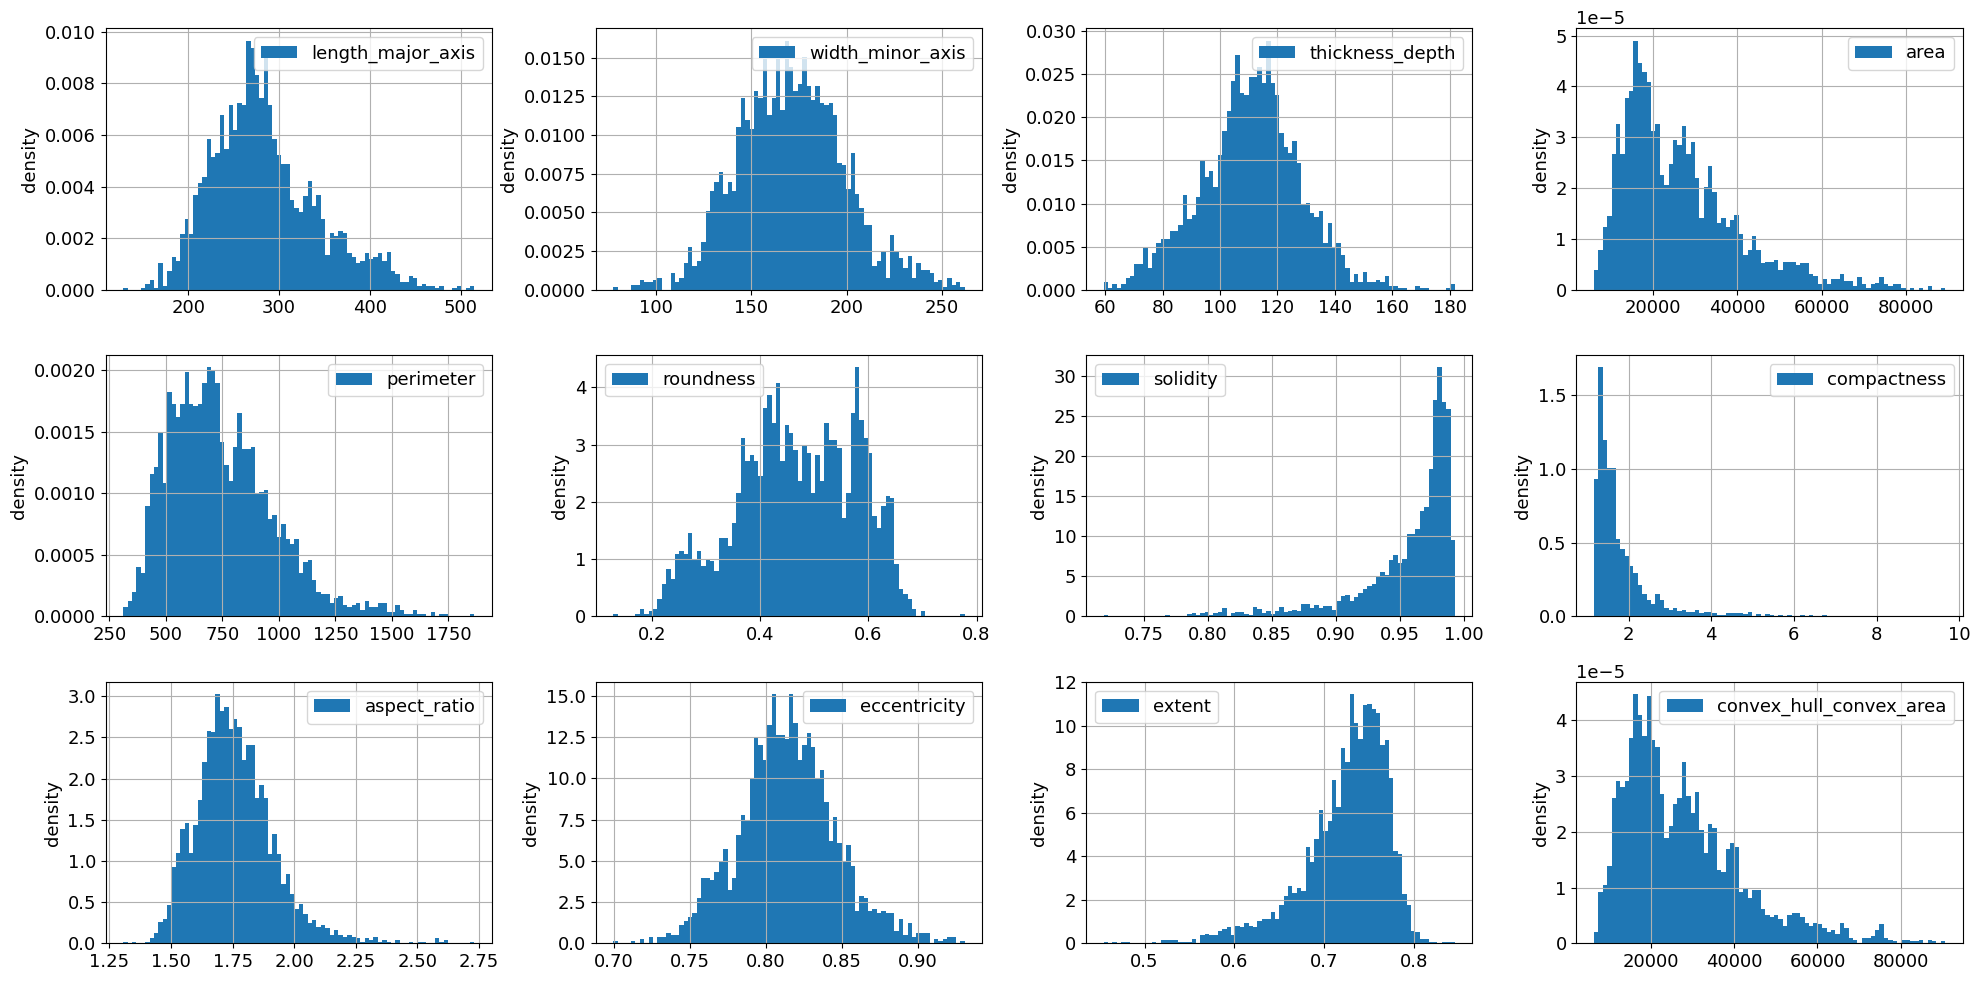

\begin{table}[!ht]
	\caption{Properties of each feature}
	\begin{center}
		\begin{tabular}{crrrrrrrr}
			Column Name & Non-Null Count & Mean & Minimum Value & Maximum Value & Standard Deviation & Variance & Skewness & Kurtosis \\
			\hline
			Length (major axis) & 2803.000 & 284.074 & 128.481 & 515.352 & 58.411 & 3411.889 & 0.712 & 0.481 \\
			Width (minor axis) & 2803.000 & 171.079 & 77.714 & 261.920 & 28.021 & 785.201 & 0.198 & 0.140 \\
			Thickness (depth) & 2803.000 & 110.753 & 59.494 & 181.845 & 17.435 & 303.967 & 0.045 & 0.408 \\
			Area & 2803.000 & 26511.117 & 6037.000 & 89282.000 & 13782.561 & 189958997.193 & 1.242 & 1.627 \\
			Perimeter & 2803.000 & 743.864 & 311.563 & 1864.947 & 230.632 & 53191.154 & 0.919 & 1.130 \\
			Roundness & 2803.000 & 0.467 & 0.128 & 0.778 & 0.110 & 0.012 & -0.267 & -0.650 \\
			Solidity & 2803.000 & 0.956 & 0.719 & 0.993 & 0.040 & 0.002 & -2.175 & 5.460 \\
			Compactness & 2803.000 & 1.825 & 1.164 & 9.660 & 0.794 & 0.631 & 3.218 & 14.887 \\
			Aspe

In [7]:
table_list = [
    ["Column Name", "Non-Null Count", "Mean", "Minimum Value", "Maximum Value", "Standard Deviation", "Variance", "Skewness", "Kurtosis"]
]

plt.figure(1, (20, 10), dpi=100)
idx = 0
for lab, col in col_names__renaming.items():

    if col != 'almond_type':
        idx += 1
        table_list.append(
            [
                lab,
                df__filled__distribution[col].count(),
                df__filled__distribution[col].mean(),
                df__filled__distribution[col].min(),
                df__filled__distribution[col].max(),
                df__filled__distribution[col].std(),
                df__filled__distribution[col].var(),
                df__filled__distribution[col].skew(),
                df__filled__distribution[col].kurtosis(),
            ]
        )

        plt.subplot(3, 4, idx)
        plt.hist(df__filled__distribution[col], bins=80, density=True, label=col)
        plt.ylabel("density")
        plt.legend()
        plt.grid()

plt.tight_layout()
plt.savefig("report/assets/data__distributions__distr_filled", dpi=200)
plt.show()

# Create Tables
table_1 = Texttable()
table_1.set_cols_align(["c"]+["r"]*8)
table_1.set_cols_valign(["m"]*9)
table_1.set_cols_dtype(['t']+['f']*8)
table_1.set_deco(Texttable.HEADER )
table_1.set_precision(3)
table_1.add_rows(
    table_list
)


# print(table_1.draw())
print(latextable.draw_latex(
    table_1,
    caption="Properties of each feature",
    label="tab:prop_of_features",
    position='!ht',
    caption_above=True
))

| **Column Name**          | **Non-Null Count** | **Mean**  | **Minimum Value** | **Maximum Value** | **Standard Deviation** | **Variance**  | **Skewness** | **Kurtosis** |
|:------------------------:|:------------------:|:---------:|:-----------------:|:-----------------:|:----------------------:|:-------------:|:------------:|:------------:|
| Length (major axis)      | 2803.000           | 284.335   | 143.941           | 515.352           | 58.645                 | 3439.291      | 0.688        | 0.445        |
| Width (minor axis)       | 2803.000           | 170.613   | 88.051            | 258.570           | 28.276                 | 799.524       | 0.143        | 0.042        |
| Thickness (depth)        | 2803.000           | 110.601   | 59.494            | 181.845           | 17.555                 | 308.168       | 0.085        | 0.414        |
| Area                     | 2803.000           | 26511.117 | 6037.000          | 89282.000         | 13782.561              | 189958997.193 | 1.242        | 1.627        |
| Perimeter                | 2803.000           | 743.864   | 311.563           | 1864.947          | 230.632                | 53191.154     | 0.919        | 1.130        |
| Roundness                | 2803.000           | 0.467     | 0.174             | 0.697             | 0.110                  | 0.012         | -0.248       | -0.685       |
| Solidity                 | 2803.000           | 0.956     | 0.719             | 0.993             | 0.040                  | 0.002         | -2.175       | 5.460        |
| Compactness              | 2803.000           | 1.825     | 1.164             | 9.660             | 0.794                  | 0.631         | 3.218        | 14.887       |
| Aspect Ratio             | 2803.000           | 1.759     | 1.361             | 2.731             | 0.161                  | 0.026         | 1.009        | 2.773        |
| Eccentricity             | 2803.000           | 0.814     | 0.700             | 0.931             | 0.032                  | 0.001         | 0.200        | 0.394        |
| Extent                   | 2803.000           | 0.725     | 0.455             | 0.846             | 0.047                  | 0.002         | -1.333       | 2.680        |
| Convex hull(convex area) | 2803.000           | 27696.218 | 6355.000          | 90642.500         | 14237.348              | 202702066.975 | 1.230        | 1.607        |


### Data Processing 

Data will be split into training and testing sets then a validation set is pulled out of the training set.
```tex    
@book{Goodfellow-et-al-2016,
    title={Deep Learning},
    author={Ian Goodfellow and Yoshua Bengio and Aaron Courville},
    publisher={MIT Press},
    note={\url{http://www.deeplearningbook.org}},
    year={2016}
}
```


#### Splitting and Standardising Data

In [8]:
rand_state = 24
k_folds = 8
test_ratio = 0.15

test_n = np.ceil(data__df.shape[0]*test_ratio)
train_n = np.floor(data__df.shape[0]*(1-test_ratio))
k_fold_valid_n = np.ceil(train_n * 1/8)
k_fold_train_n = np.floor(train_n * 7/8)

print(f"test:\t {test_n}")
print(f"train:\t{train_n} -> {k_fold_valid_n, k_fold_train_n}")
print(f"n:\t{data__df.shape[0]}")

total_data__dict = {
    "df__dropped__cols": {
        "raw": df__dropped__cols
    },
    "df__filled__means": {
        "raw": df__filled__means
    },
    "df__filled__distribution": {
        "raw": df__filled__distribution
    },
    "data__df": {
        "raw": data__df
    },
}

# splitting and standardise of data
for df__key in total_data__dict.keys():

    # one-hot encoding of target
    df__encoded = pd.get_dummies(total_data__dict[df__key]['raw'], columns=['almond_type'])
    total_data__dict[df__key]['raw'] = df__encoded

    train_split, test_split = train_test_split(
        total_data__dict[df__key]['raw'],
        test_size=test_ratio,
        shuffle=True,
        random_state=rand_state
    )
    
    # standardise
    cols = list(train_split.columns.values)[:-3]
    scalar = preprocessing.StandardScaler().fit(train_split[cols])
    test_split[cols] = scalar.transform(test_split[cols])
    train_split[cols] = scalar.transform(train_split[cols])


    total_data__dict[df__key][f'test_set'] = test_split
    total_data__dict[df__key][f'train_set'] = train_split
    
    k_folder = KFold(n_splits=k_folds, shuffle=True, random_state=rand_state)

    for idx, (sub_train, sub_valid) in enumerate(k_folder.split(train_split)):
        total_data__dict[df__key][f'k_fold_train_{idx}'] = train_split.iloc[sub_train]
        total_data__dict[df__key][f'k_fold_valid_{idx}'] = train_split.iloc[sub_valid]



test:	 421.0
train:	2382.0 -> (298.0, 2084.0)
n:	2803


### Saving Processed Data

In [9]:
# for dataset_key, dataset in total_data__dict.items():
#     for subset_key, subset in dataset.items():
#         subset.to_csv(f"data/{dataset_key}/{subset_key}.csv")


## Hyperparameter Optimisation

In [9]:
%env MLFLOW_TRACKING_URI=sqlite:///mlruns.db
exp_name = 'cos711_ass_2__hyperparam_v1'
mlflow.set_experiment(exp_name)
logger = logging.getLogger("mlflow")
# Set log level to DEBUG
logger.setLevel(logging.ERROR)

env: MLFLOW_TRACKING_URI=sqlite:///mlruns.db


2024/10/02 12:57:42 INFO mlflow.store.db.utils: Creating initial MLflow database tables...
2024/10/02 12:57:42 INFO mlflow.store.db.utils: Updating database tables
INFO  [alembic.runtime.migration] Context impl SQLiteImpl.
INFO  [alembic.runtime.migration] Will assume non-transactional DDL.
INFO  [alembic.runtime.migration] Context impl SQLiteImpl.
INFO  [alembic.runtime.migration] Will assume non-transactional DDL.


### Steps

Reasons are need. Acceptable reasons are:
1. Theoretical Insight
2. Empirical Evidence

Hyperparameters to Optimise:
- loss
    - MAE
    - MSE
    - RMSE
    - Cross-Entropy
    - Custom
    - regularisation
        - L1
        - L2
        - Custom

- activation functions
    - ReLu
    - SeLu
    - Sigmoid
    - Tanh
        - LeCun TanH
    - Elliot
    - Softmax

- structure
    - Length (number of neurons per layer)
    - Width (number of Neurons)
    - Drop-out
    - Pruning

- optimisers
    - type of optimiser
        - Adam
        - AdaDelta
        - AdaGrad
        - NAG
        - SGD
        - RMSProp
    - learning rate
        - Warm-up
        - Decay
    - momentum
    - early stoppage

### Helper Functions

In [20]:
def generate_ml_run_name(word_length=3, num_words=2):
    """
    Generate a random short name for ML runs.
    
    Args:
    word_length (int): Length of each word in the name. Default is 3.
    num_words (int): Number of words in the name. Default is 2.
    
    Returns:
    str: A randomly generated name for an ML run.
    """
    consonants = 'bcdfghjklmnpqrstvwxyz'
    vowels = 'aeiou'
    
    def generate_word():
        word = ''
        for i in range(word_length):
            if i % 2 == 0:
                word += random.choice(consonants)
            else:
                word += random.choice(vowels)
        return word
    
    words = [generate_word() for _ in range(num_words)]
    return '_'.join(words)


def create_tf_dataset(X, y, batch_size=32, shuffle=True, prefetch=True):
    dataset = tf.data.Dataset.from_tensor_slices((X.values, y.values))
    
    if shuffle:
        dataset = dataset.shuffle(buffer_size=len(X))
    
    dataset = dataset.batch(batch_size)
    
    if prefetch:
        dataset = dataset.prefetch(tf.data.AUTOTUNE)
    
    return dataset



def get_metric(run_id: str, metric: str) -> np.ndarray:
    client = mlflow.tracking.MlflowClient()
    list_metric_hist = client.get_metric_history(run_id=run_id, key=metric)
    return np.array([
        m.value for m in list_metric_hist
    ])


class AveragingCallback(tf.keras.callbacks.Callback):
    def __init__(self, k_folds, metrics):
        super().__init__()
        self.k_folds = k_folds
        self.metrics = metrics + ['loss']
        self.current_fold = 0
        self.sum_metrics = {m: np.zeros(epochs) for m in self.metrics + [f'val_{m}' for m in self.metrics]}
        self.parent_run_id = None

    def set_parent_run_id(self, run_id):
        self.parent_run_id = run_id

    def on_train_begin(self, logs=None):
        self.current_fold += 1

    def on_epoch_end(self, epoch, logs=None):
        for metric in self.metrics:
            if len(self.sum_metrics[metric]) <= epoch:
                self.sum_metrics[metric].append(0)
                self.sum_metrics[f'val_{metric}'].append(0)
            
            self.sum_metrics[metric][epoch] += logs.get(metric, 0)
            self.sum_metrics[f'val_{metric}'][epoch] += logs.get(f'val_{metric}', 0)
        
        # Calculate and log running averages
        if self.current_fold == self.k_folds:
            for metric in self.metrics:
                avg_train = self.sum_metrics[metric][epoch] / self.k_folds
                avg_val = self.sum_metrics[f'val_{metric}'][epoch] / self.k_folds
                mlflow.log_metric(f"{metric}", avg_train, step=epoch, run_id=self.parent_run_id)
                mlflow.log_metric(f"val_{metric}", avg_val, step=epoch, run_id=self.parent_run_id)

    def on_train_end(self, logs=None):
        if self.current_fold == self.k_folds:
            # Log final averages
            for metric in self.metrics:
                final_avg_train = np.mean(self.sum_metrics[metric] / self.k_folds)
                final_avg_val = np.mean(self.sum_metrics[f'val_{metric}'] / self.k_folds)
                # mlflow.log_metric(f"final_avg_{metric}", final_avg_train, run_id=self.parent_run_id)
                mlflow.log_metric(f"validation_{metric}", final_avg_val, run_id=self.parent_run_id)

def average_metrics(metrics_list):
    return {k: np.mean([d[k] for d in metrics_list]) for k in metrics_list[0]}


### Data Loader

In [5]:
k_folds_num = 8
training_dataset_name = 'df__filled__means'
total_data__dict = {training_dataset_name: {}}
for k in range(k_folds_num):
    total_data__dict[training_dataset_name][f'k_fold_train_{k}'] = pd.read_csv(f"./data/{training_dataset_name}/k_fold_train_{k}.csv")
    total_data__dict[training_dataset_name][f'k_fold_valid_{k}'] = pd.read_csv(f"./data/{training_dataset_name}/k_fold_valid_{k}.csv")



### Simple Baseline Model

#### Setup

In [6]:
inp_layer_units = 12
out_layer_units = 3
hid_layer_units = 100
hid_layer_number= 5
activation_func = 'relu'
loss_func       = 'binary_crossentropy'
learning_rate   = 0.005
adam_optimiser  = tf.keras.optimizers.Adam()
epochs = int(2**6)
early_stop_callback = tf.keras.callbacks.EarlyStopping(
    monitor='val_accuracy',
    min_delta=0,
    patience=10,
    verbose=0,
    mode='max',
    baseline=0.75,
    restore_best_weights=True,
    start_from_epoch=50
)
dropout_rate = 0.1
dropout_seed = 24


input_layer = [tf.keras.layers.Input(shape=(inp_layer_units,), name='input_layer')]
output_layer = [tf.keras.layers.Dense(units=out_layer_units, activation='softmax', name='output_layer')]
hidden_layers = []
for idx in range(hid_layer_number):
    hidden_layers.append(
        tf.keras.layers.Dense(units=hid_layer_units, activation=activation_func, name=f'hidden_layer__{idx}')
    )
    hidden_layers.append(
        tf.keras.layers.Dropout(rate=dropout_rate, seed=dropout_seed, name=f"dropout_layer__{idx}")
    )

model_baseline = tf.keras.Sequential(
    layers=input_layer+hidden_layers+output_layer,
    name="Baseline"
)


#### Training

In [31]:
# training
feature_list = [
    'length_major_axis',
    'width_minor_axis',
    'thickness_depth',
    'area',
    'perimeter', 'roundness',
    'solidity',
    'compactness',
    'aspect_ratio',
    'eccentricity',
    'extent',
    'convex_hull_convex_area'
]
target_list = ['almond_type_MAMRA', 'almond_type_REGULAR', 'almond_type_SANORA']
metrics = ['accuracy', "recall", "precision"]
baseline_history = {}

# mlflow tracking
flow_name__main = 'baseline_model'

# Total training
for dataset in ["df__filled__distribution", "df__filled__means"]:
    with mlflow.start_run(run_name=f"{flow_name__main}__{dataset[12:17]}") as parent_run:
        parent_run_id = parent_run.info.run_id
        fold_metrics = {metric: [] for metric in metrics}
        fold_metrics.update({f"val_{metric}": [] for metric in metrics})
        
        averaging_callback = AveragingCallback(k_folds, metrics)
        averaging_callback.set_parent_run_id(parent_run_id)
        
        for k in range(k_folds):
            flow_name = f"{flow_name__main}__{dataset[12:17]}__k{k}"
            
            with mlflow.start_run(run_name=flow_name, nested=True) as child_run:
                adam_optimiser  = tf.keras.optimizers.Adam(learning_rate=0.005)

                model = tf.keras.models.clone_model(model_baseline)
                model.compile(optimizer=adam_optimiser, loss=loss_func, metrics=metrics)

                training_set = total_data__dict[dataset][f'k_fold_train_{k}']
                validating_set = total_data__dict[dataset][f'k_fold_valid_{k}']

                X_train, y_train = training_set[feature_list], training_set[target_list]
                X_valid, y_valid = validating_set[feature_list], validating_set[target_list]

                batch_size = 32  # Adjust this value based on your needs
                train_dataset = create_tf_dataset(X_train, y_train, batch_size=batch_size)
                valid_dataset = create_tf_dataset(X_valid, y_valid, batch_size=batch_size, shuffle=False)


                k_fold_hist = model.fit(
                    train_dataset,
                    validation_data=valid_dataset,
                    epochs=epochs,
                    callbacks=[mlflow.keras.MlflowCallback(), averaging_callback],
                    verbose=0
                )
                params = {
                    "loss" : loss_func,
                    "hid_layer_units" : hid_layer_units,
                    "hid_layer_number" : hid_layer_number,
                    "activation_func" : activation_func,
                    "learning_rate" : learning_rate,
                    "epochs" : epochs,
                    "dropout_rate" : dropout_rate,
                    "df__fill_type": dataset
                }
                
                # Log parameters
                mlflow.log_params(params, run_id=child_run.info.run_id)

                # log metrics
                for metric in metrics:
                    if metric == 'f1_score':
                        mlflow.log_metric(f"final_train_{metric}_case0", k_fold_hist.history[metric][-1][0])
                        mlflow.log_metric(f"final_val_{metric}_case0", k_fold_hist.history[f'val_{metric}'][-1][0])
                        mlflow.log_metric(f"final_train_{metric}_case1", k_fold_hist.history[metric][-1][1])
                        mlflow.log_metric(f"final_val_{metric}_case1", k_fold_hist.history[f'val_{metric}'][-1][1])
                        mlflow.log_metric(f"final_train_{metric}_case2", k_fold_hist.history[metric][-1][2])
                        mlflow.log_metric(f"final_val_{metric}_case2", k_fold_hist.history[f'val_{metric}'][-1][2])

                    else:
                        mlflow.log_metric(f"final_train_{metric}", k_fold_hist.history[metric][-1])
                        mlflow.log_metric(f"final_val_{metric}", k_fold_hist.history[f'val_{metric}'][-1])
                

                baseline_history[flow_name] = {
                    'history': k_fold_hist,
                    'params': params
                }
                print(f"Completed: k_fold_{k}")
        mlflow.log_params(params, run_id=parent_run_id)


Completed: k_fold_0


Completed: k_fold_1


Completed: k_fold_2


Completed: k_fold_3


Completed: k_fold_4


Completed: k_fold_5


Completed: k_fold_6


Completed: k_fold_7


Completed: k_fold_0


Completed: k_fold_1


Completed: k_fold_2


Completed: k_fold_3


Completed: k_fold_4


Completed: k_fold_5


Completed: k_fold_6


Completed: k_fold_7


In [29]:
mlflow.end_run()

#### Plotting

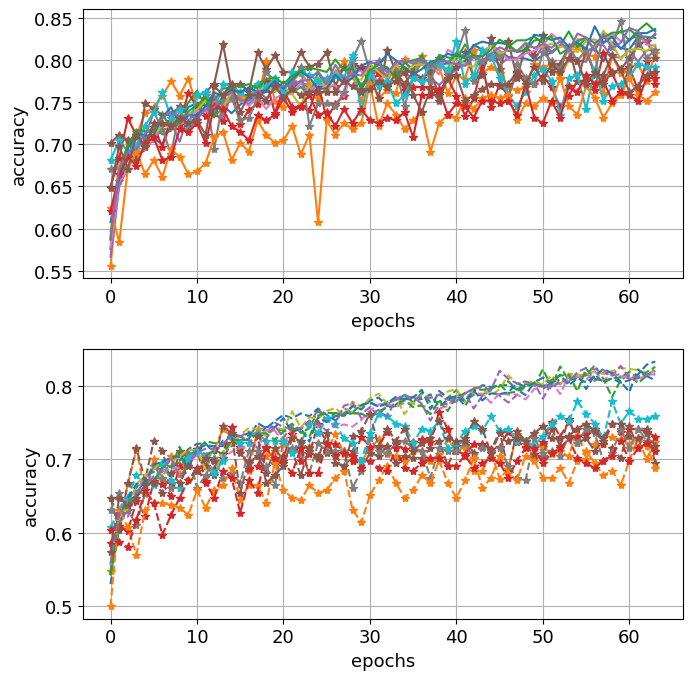

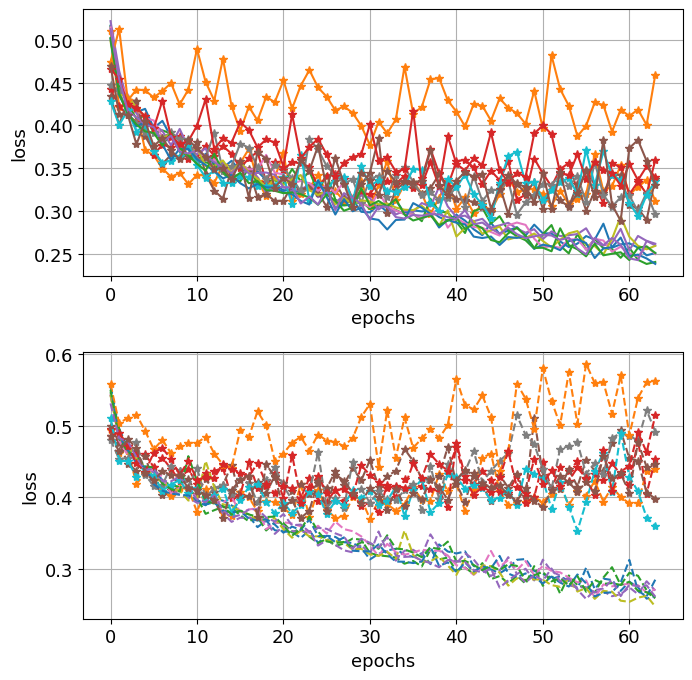

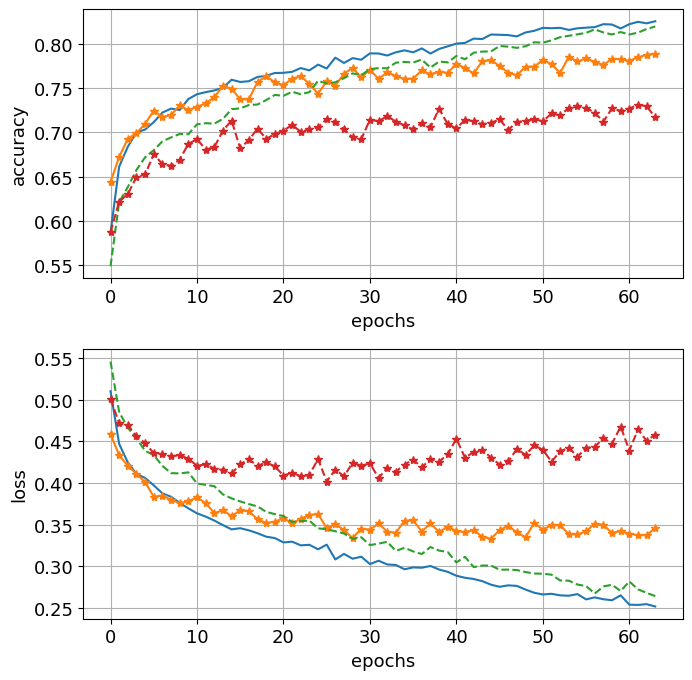

In [12]:
# exp = mlflow.get_experiment(experiment_id=1)
all_runs = mlflow.search_runs(experiment_names=[exp_name])
basemodel_run_ids = [
    all_runs['run_id'].where(all_runs['tags.mlflow.runName'] == 'baseline_model__means').dropna().iloc[0],
    all_runs['run_id'].where(all_runs['tags.mlflow.runName'] == 'baseline_model__distr').dropna().iloc[0],
]


# filter out non-basemodel runs
basemodel_subruns = all_runs.where(all_runs['tags.mlflow.parentRunId'].isin(basemodel_run_ids)).dropna(how='all')
basemodel_runs = all_runs.where(all_runs['run_id'].isin(basemodel_run_ids)).dropna(how='all')
metrics_of_interest = ['accuracy', "recall", "precision", 'val_accuracy', "val_recall", "val_precision", "loss", "val_loss"]

# accuracy
for metric in ['accuracy', 'loss']:
    plt.figure(1, (7, 7), dpi=100)
    for run_id, run_name in basemodel_subruns[['run_id', 'tags.mlflow.runName']].to_numpy():
        run_type, run_data, k = run_name.split(sep="__")

        if run_type == "baseline_model" and run_data == "means":
            plt.subplot(2, 1, 1)
            # plt.title("Data with Nulls Filled with Means")
            train_metric = get_metric(run_id, metric)
            valid_metric = get_metric(run_id, f'val_{metric}')

            plt.plot(train_metric, label=f"{k}")
            plt.plot(valid_metric, marker='*', label=f"val_{k}")

            # plt.legend()
            plt.ylabel(metric)
            plt.xlabel("epochs")
            plt.grid(True)

        elif run_type == "baseline_model" and run_data == "distr":
            plt.subplot(2, 1, 2)
            # plt.title("Data with Nulls Filled with Samples from Distribution")
            train_metric = get_metric(run_id, metric)
            valid_metric = get_metric(run_id, f'val_{metric}')

            plt.plot(train_metric, ls='--', label=f"{k}")
            plt.plot(valid_metric, ls='--', marker='*', label=f"val_{k}")

            # plt.legend()
            plt.xlabel("epochs")
            plt.ylabel(metric)
            plt.grid(True)


    plt.tight_layout()
    plt.savefig(f"report/assets/baseline__kfold__{metric}", dpi=200)
    plt.show()


plt.figure(1, (7, 7), dpi=100)
for run_id, run_name in basemodel_runs[['run_id', 'tags.mlflow.runName']].to_numpy():
    run_type, run_data = run_name.split(sep="__")

    if run_data == 'distr':
        line_style='--'
    else:
        line_style="-"

    plt.subplot(2, 1, 1)
    # plt.title("Accuracy")
    train_metric = get_metric(run_id, 'accuracy')
    valid_metric = get_metric(run_id, f'val_accuracy')

    plt.plot(train_metric, ls=line_style, label=f"{run_name}")
    plt.plot(valid_metric, ls=line_style, marker='*', label=f"val_{run_name}")

    # plt.legend()
    plt.ylabel("accuracy")
    plt.xlabel("epochs")
    plt.grid(True)

    plt.subplot(2, 1, 2)
    # plt.title("Loss")
    train_metric = get_metric(run_id, 'loss')
    valid_metric = get_metric(run_id, f'val_loss')

    plt.plot(train_metric, ls=line_style, label=f"{run_name}")
    plt.plot(valid_metric, ls=line_style, marker='*', label=f"val_{run_name}")

    # plt.legend()
    plt.xlabel("epochs")
    plt.ylabel('loss')
    plt.grid(True)


plt.tight_layout()
plt.savefig(f"report/assets/baseline__acc_and_loss", dpi=200)
plt.show()


In [ ]:

# #############################
# ## get avg per k
# #############################
# avg_k__batching_mean__acc__train = []
# avg_k__batching_mean__acc__valid = []
# avg_k__batching_dist__acc__train = []
# avg_k__batching_dist__acc__valid = []
# avg_k__batching_mean__loss__train = []
# avg_k__batching_mean__loss__valid = []
# avg_k__batching_dist__loss__train = []
# avg_k__batching_dist__loss__valid = []
# avg_k__non_batching_mean__acc__train = []
# avg_k__non_batching_mean__acc__valid = []
# avg_k__non_batching_dist__acc__train = []
# avg_k__non_batching_dist__acc__valid = []
# avg_k__non_batching_mean__loss__train = []
# avg_k__non_batching_mean__loss__valid = []
# avg_k__non_batching_dist__loss__train = []
# avg_k__non_batching_dist__loss__valid = []

# for run_id, run_name in sub_runs.to_np():
#     run_type, run_data, k = run_name.split(sep="__")
#     if run_type == "baseline_model_with_batching" and run_data == "means":
#         avg_k__batching_mean__acc__train.append(get_metric(run_id, 'accuracy'))
#         avg_k__batching_mean__acc__valid.append(get_metric(run_id, 'val_accuracy'))
#         avg_k__batching_mean__loss__train.append(get_metric(run_id, 'loss'))
#         avg_k__batching_mean__loss__valid.append(get_metric(run_id, 'val_loss'))

#     elif run_type == "baseline_model_with_batching" and run_data == "distr":
#         avg_k__batching_dist__acc__train.append(get_metric(run_id, 'accuracy'))
#         avg_k__batching_dist__acc__valid.append(get_metric(run_id, 'val_accuracy'))
#         avg_k__batching_dist__loss__train.append(get_metric(run_id, 'loss'))
#         avg_k__batching_dist__loss__valid.append(get_metric(run_id, 'val_loss'))

#     elif run_type == "baseline_model" and run_data == "means":
#         avg_k__non_batching_mean__acc__train.append(get_metric(run_id, 'accuracy'))
#         avg_k__non_batching_mean__acc__valid.append(get_metric(run_id, 'val_accuracy'))
#         avg_k__non_batching_mean__loss__train.append(get_metric(run_id, 'loss'))
#         avg_k__non_batching_mean__loss__valid.append(get_metric(run_id, 'val_loss'))

#     elif run_type == "baseline_model" and run_data == "distr":
#         avg_k__non_batching_dist__acc__train.append(get_metric(run_id, 'accuracy'))
#         avg_k__non_batching_dist__acc__valid.append(get_metric(run_id, 'val_accuracy'))
#         avg_k__non_batching_dist__loss__train.append(get_metric(run_id, 'loss'))
#         avg_k__non_batching_dist__loss__valid.append(get_metric(run_id, 'val_loss'))

# avg_k__batching_mean__acc__train = np.mean(np.array(avg_k__batching_mean__acc__train), axis=0)
# avg_k__batching_mean__acc__valid = np.mean(np.array(avg_k__batching_mean__acc__valid), axis=0)
# avg_k__batching_dist__acc__train = np.mean(np.array(avg_k__batching_dist__acc__train), axis=0)
# avg_k__batching_dist__acc__valid = np.mean(np.array(avg_k__batching_dist__acc__valid), axis=0)
# avg_k__batching_mean__loss__train = np.mean(np.array(avg_k__batching_mean__loss__train), axis=0)
# avg_k__batching_mean__loss__valid = np.mean(np.array(avg_k__batching_mean__loss__valid), axis=0)
# avg_k__batching_dist__loss__train = np.mean(np.array(avg_k__batching_dist__loss__train), axis=0)
# avg_k__batching_dist__loss__valid = np.mean(np.array(avg_k__batching_dist__loss__valid), axis=0)
# avg_k__non_batching_mean__acc__train = np.mean(np.array(avg_k__non_batching_mean__acc__train), axis=0)
# avg_k__non_batching_mean__acc__valid = np.mean(np.array(avg_k__non_batching_mean__acc__valid), axis=0)
# avg_k__non_batching_dist__acc__train = np.mean(np.array(avg_k__non_batching_dist__acc__train), axis=0)
# avg_k__non_batching_dist__acc__valid = np.mean(np.array(avg_k__non_batching_dist__acc__valid), axis=0)
# avg_k__non_batching_mean__loss__train = np.mean(np.array(avg_k__non_batching_mean__loss__train), axis=0)
# avg_k__non_batching_mean__loss__valid = np.mean(np.array(avg_k__non_batching_mean__loss__valid), axis=0)
# avg_k__non_batching_dist__loss__train = np.mean(np.array(avg_k__non_batching_dist__loss__train), axis=0)
# avg_k__non_batching_dist__loss__valid = np.mean(np.array(avg_k__non_batching_dist__loss__valid), axis=0)



# #############################
# ## plot avg per k
# #############################
# plt.figure(1, (7.5, 10))

# plt.subplot(2, 1, 1)
# plt.plot(avg_k__batching_mean__acc__train, label='Series A')
# plt.plot(avg_k__non_batching_mean__acc__train, label='Series B')
# plt.plot(avg_k__batching_dist__acc__train, label='Series C')
# plt.plot(avg_k__non_batching_dist__acc__train, label='Series D')
# plt.plot(avg_k__batching_mean__acc__valid, marker="*", label='Series E')
# plt.plot(avg_k__non_batching_mean__acc__valid, marker="*", label='Series F')
# plt.plot(avg_k__batching_dist__acc__valid, marker="*", label='Series G')
# plt.plot(avg_k__non_batching_dist__acc__valid, marker="*", label='Series H')
# plt.legend()
# plt.grid()
# plt.xlabel('epochs')
# plt.ylabel('accuracy')

# plt.subplot(2, 1, 2)
# plt.plot(avg_k__batching_mean__loss__train, label='Series A')
# plt.plot(avg_k__non_batching_mean__loss__train, label='Series B')
# plt.plot(avg_k__batching_dist__loss__train, label='Series C')
# plt.plot(avg_k__non_batching_dist__loss__train, label='Series D')
# plt.plot(avg_k__batching_mean__loss__valid, marker="*", label='Series E')
# plt.plot(avg_k__non_batching_mean__loss__valid, marker="*", label='Series F')
# plt.plot(avg_k__batching_dist__loss__valid, marker="*", label='Series G')
# plt.plot(avg_k__non_batching_dist__loss__valid, marker="*", label='Series H')

# plt.legend(loc='lower left')
# plt.grid()
# plt.xlabel('epochs')
# plt.ylabel('loss')

# plt.tight_layout()
# plt.savefig("report/assets/baseline__avg__accuracy_and_loss", dpi=200)
# plt.show()



### Hyperparameter Iteration

#### Setup

In [4]:
#############################################################
## static parameters 
#############################################################
inp_layer_units = 12
out_layer_units = 3
dropout_seed = 24
#######################

comb_loss = ['binary_crossentropy']
comb_hid_layer_units = [int(2**h) for h in range(5, 10)]
comb_hid_layer_number= [n for n in range(1, 11)]
comb_activation_func = ['relu']
comb_learning_rate   = [0.001]
comb_epochs = [int(2**9)]
comb_dropout_rate = [0.2]


activation_func = comb_activation_func[0]
loss_func       = comb_loss[0]
learning_rate   = comb_learning_rate[0]
adam_optimiser  = tf.keras.optimizers.Adam(learning_rate=learning_rate)
epochs = comb_epochs[0]
dropout_rate = comb_dropout_rate[0]

feature_list = [
    'length_major_axis',
    'width_minor_axis',
    'thickness_depth',
    'area',
    'perimeter', 'roundness',
    'solidity',
    'compactness',
    'aspect_ratio',
    'eccentricity',
    'extent',
    'convex_hull_convex_area'
]
target_list = ['almond_type_MAMRA', 'almond_type_REGULAR', 'almond_type_SANORA']
metrics = ['accuracy', "recall", "precision"]

class AveragingCallback(tf.keras.callbacks.Callback):
    def __init__(self, k_folds, metrics):
        super().__init__()
        self.k_folds = k_folds
        self.metrics = metrics + ['loss']
        self.current_fold = 0
        self.sum_metrics = {m: np.zeros(epochs) for m in self.metrics + [f'val_{m}' for m in self.metrics]}
        self.parent_run_id = None

    def set_parent_run_id(self, run_id):
        self.parent_run_id = run_id

    def on_train_begin(self, logs=None):
        self.current_fold += 1

    def on_epoch_end(self, epoch, logs=None):
        for metric in self.metrics:
            if len(self.sum_metrics[metric]) <= epoch:
                self.sum_metrics[metric].append(0)
                self.sum_metrics[f'val_{metric}'].append(0)
            
            self.sum_metrics[metric][epoch] += logs.get(metric, 0)
            self.sum_metrics[f'val_{metric}'][epoch] += logs.get(f'val_{metric}', 0)
        
        # Calculate and log running averages
        if self.current_fold == self.k_folds:
            for metric in self.metrics:
                avg_train = self.sum_metrics[metric][epoch] / self.k_folds
                avg_val = self.sum_metrics[f'val_{metric}'][epoch] / self.k_folds
                mlflow.log_metric(f"{metric}", avg_train, step=epoch, run_id=self.parent_run_id)
                mlflow.log_metric(f"val_{metric}", avg_val, step=epoch, run_id=self.parent_run_id)

    def on_train_end(self, logs=None):
        if self.current_fold == self.k_folds:
            # Log final averages
            for metric in self.metrics:
                final_avg_train = np.mean(self.sum_metrics[metric] / self.k_folds)
                final_avg_val = np.mean(self.sum_metrics[f'val_{metric}'] / self.k_folds)
                # mlflow.log_metric(f"final_avg_{metric}", final_avg_train, run_id=self.parent_run_id)
                mlflow.log_metric(f"validation_{metric}", final_avg_val, run_id=self.parent_run_id)

def average_metrics(metrics_list):
    return {k: np.mean([d[k] for d in metrics_list]) for k in metrics_list[0]}


#### Training

In [103]:
for hid_layer_unit in comb_hid_layer_units:
    for hid_layer_number in comb_hid_layer_number:
        #################
        ## setup model
        #################
        input_layer = [tf.keras.layers.Input(shape=(inp_layer_units,), name='input_layer')]
        output_layer = [tf.keras.layers.Dense(units=out_layer_units, activation='softmax', name='output_layer')]
        hidden_layers = []
        for idx in range(hid_layer_number):
            hidden_layers.append(
                tf.keras.layers.Dense(units=hid_layer_unit, activation=activation_func, name=f'hidden_layer__{idx}')
            )
            hidden_layers.append(
                tf.keras.layers.Dropout(rate=dropout_rate, seed=dropout_seed, name=f"dropout_layer__{idx}")
            )
        base_model_name = generate_ml_run_name(4, 2)

        model_base = tf.keras.Sequential(
            layers=input_layer+hidden_layers+output_layer,
            name=base_model_name
        )

        ##################
        ## training
        ##################
        flow_name__main = base_model_name
        with mlflow.start_run(run_name=flow_name__main) as parent_run:
            parent_run_id = parent_run.info.run_id


            averaging_callback = AveragingCallback(k_folds, metrics)
            averaging_callback.set_parent_run_id(parent_run_id)

            # Total training
            dataset = "df__filled__means"
                
            for k in range(k_folds):
                flow_name = f"{flow_name__main}__k{k}"
                
                with mlflow.start_run(run_name=flow_name, nested=True) as child_run:
                    adam_optimiser  = tf.keras.optimizers.Adam(learning_rate=learning_rate)

                    model = tf.keras.models.clone_model(model_base)
                    model.compile(optimizer=adam_optimiser, loss=loss_func, metrics=metrics)

                    training_set = total_data__dict[dataset][f'k_fold_train_{k}']
                    validating_set = total_data__dict[dataset][f'k_fold_valid_{k}']

                    X_train, y_train = training_set[feature_list], training_set[target_list]
                    X_valid, y_valid = validating_set[feature_list], validating_set[target_list]

                    batch_size = 32  # Adjust this value based on your needs
                    train_dataset = create_tf_dataset(X_train, y_train, batch_size=batch_size)
                    valid_dataset = create_tf_dataset(X_valid, y_valid, batch_size=batch_size, shuffle=False)

                    k_fold_hist = model.fit(
                        train_dataset,
                        validation_data=valid_dataset,
                        epochs=epochs,
                        callbacks=[mlflow.keras.MlflowCallback(), averaging_callback],
                        verbose=0
                    )
                    params = {
                        "loss" : loss_func,
                        "hid_layer_units" : hid_layer_units,
                        "hid_layer_number" : hid_layer_number,
                        "activation_func" : activation_func,
                        "learning_rate" : learning_rate,
                        "epochs" : epochs,
                        "dropout_rate" : dropout_rate,
                        "df__fill_type": dataset
                    }
                    
                    # Log parameters
                    mlflow.log_params(params)
        

#### Plotting

/tmp/ipykernel_67353/3862835523.py:59: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  plot_data[[


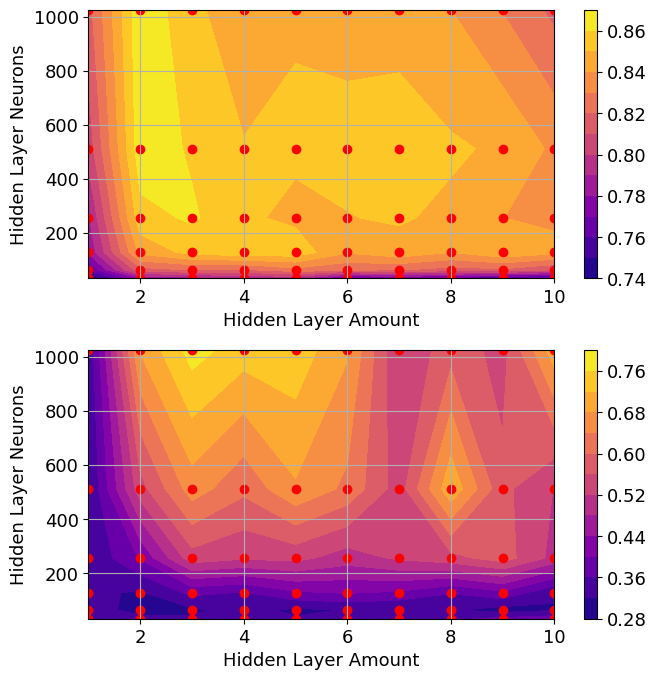

best_models_numpy: [[0.8681812584400177 0.6822001039981842 '2' '1024' 2050.6355997920036]
 [0.8665104731917381 0.543458666652441 '2' '512' 1026.9130826666951]
 [0.8614656031131744 0.5429926812648773 '3' '256' 516.9140146374702]]

big_layers_df: [[0.8547457307577133 0.85128553211689 '4' '1448']
 [0.8580971956253052 0.8395883068442345 '3' '1448']
 [0.8568416237831116 0.7466245144605637 '2' '1448']
 [0.8249440789222717 0.3382689878344536 '1' '1448']]


In [7]:
exp_name = 'cos711_ass_2__hyperparam_v1'
metrics_of_interest = ['accuracy', "recall", "precision", 'val_accuracy', "val_recall", "val_precision", "loss", "val_loss"]


all_runs = mlflow.search_runs(experiment_names=[exp_name])
basemodel_run_ids = [
    all_runs['run_id'].where(all_runs['tags.mlflow.runName'] == 'baseline_model__means').dropna().iloc[0],
    all_runs['run_id'].where(all_runs['tags.mlflow.runName'] == 'baseline_model__distr').dropna().iloc[0],
]

# filter out basemodel runs
all_runs = all_runs[~all_runs[['run_id', 'tags.mlflow.parentRunId']].isin(basemodel_run_ids).any(axis=1)].dropna(how='all')


# filter out all subruns (keep only parent runs)
all_runs = all_runs[all_runs["tags.mlflow.parentRunId"].isnull()].dropna(how='all')

# filter out hid_layer_units = 1448
big_layers = all_runs['run_id'].where(all_runs['params.hid_layer_units'] == "1448").dropna(how='all').to_numpy()
big_layers_df = all_runs[all_runs['run_id'].isin(big_layers)].dropna(how='all')
big_layers_df = big_layers_df[[
    'metrics.val_accuracy',
    'metrics.val_loss',
    'params.hid_layer_number',
    'params.hid_layer_units',
]].to_numpy()
all_runs = all_runs[~all_runs['run_id'].isin(big_layers)].dropna(how='all')

# get best models
best_models = all_runs['run_id'].where(all_runs['metrics.val_accuracy'] >= 0.86).dropna(how='all').to_numpy()
best_models_df = all_runs[all_runs['run_id'].isin(best_models)].dropna(how='all')
best_models_df['aic'] = (
    2 * (
        best_models_df['params.hid_layer_number'].astype(float)
        + best_models_df['params.hid_layer_units'].astype(float)
    )
    - 2 * np.log(np.exp(best_models_df['metrics.val_loss']))
) # aic
best_models_numpy = best_models_df[[
    'metrics.val_accuracy',
    'metrics.val_loss',
    'params.hid_layer_number',
    'params.hid_layer_units',
    'aic'
]].to_numpy()

# print(all_runs.columns.values)
plot_data = all_runs[[
    'run_id',
    'metrics.accuracy',
    'metrics.loss',
    'metrics.val_accuracy',
    'metrics.val_loss',
    'params.hid_layer_number',
    'params.hid_layer_units',
    'start_time',
    'end_time'
]]
plot_data[[
    'metrics.accuracy',
    'metrics.loss',
    'metrics.val_accuracy',
    'metrics.val_loss',
    'params.hid_layer_number',
    'params.hid_layer_units',
]] = plot_data[[
        'metrics.accuracy',
        'metrics.loss',
        'metrics.val_accuracy',
        'metrics.val_loss',
        'params.hid_layer_number',
        'params.hid_layer_units',
    ]].astype(float)


# Pivot the DataFrame
pivoted__acc = plot_data.pivot(index='params.hid_layer_units', columns='params.hid_layer_number', values='metrics.val_accuracy')
pivoted__los = plot_data.pivot(index='params.hid_layer_units', columns='params.hid_layer_number', values='metrics.val_loss')

# Create the contour plot
plt.figure(1, (7, 7), dpi=100)

plt.subplot(2, 1, 1)
contour = plt.contourf(pivoted__acc.columns, pivoted__acc.index, pivoted__acc.values, levels=12, cmap='plasma')
plt.scatter(plot_data['params.hid_layer_number'], plot_data['params.hid_layer_units'], c='r')
plt.grid()
plt.colorbar(contour)
plt.xlabel('Hidden Layer Amount')
plt.ylabel('Hidden Layer Neurons')

plt.subplot(2, 1, 2)
contour = plt.contourf(pivoted__los.columns, pivoted__los.index, pivoted__los.values, levels=12, cmap='plasma')
plt.scatter(plot_data['params.hid_layer_number'], plot_data['params.hid_layer_units'], c='r')
plt.grid()
plt.colorbar(contour)
plt.xlabel('Hidden Layer Amount')
plt.ylabel('Hidden Layer Neurons')

plt.tight_layout()
plt.savefig("report/assets/hyper_param_grid", dpi=200)
plt.show()


print(f"best_models_numpy: {best_models_numpy}")
print(f"\nbig_layers_df: {big_layers_df}")

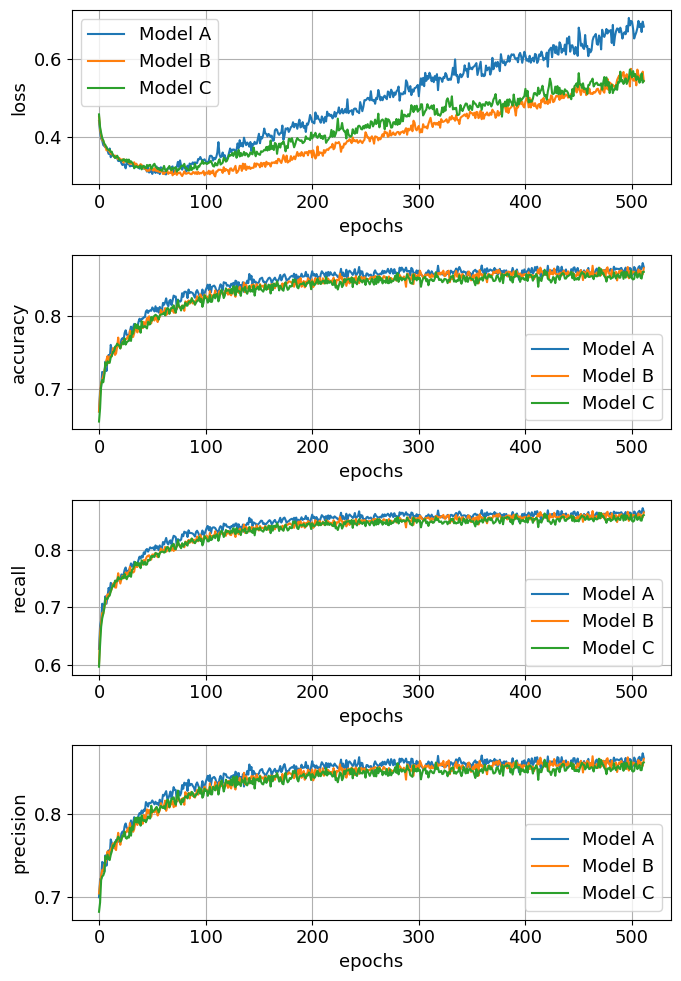

{'A': '671024e29a5c42c6a568ef4c6006205f', 'B': '5f692ea0149b4d2e926ba40e02e7d432', 'C': '014ca57352df4ee687b0a70a73691e5a'}


,run_id,params.hid_layer_number,params.hid_layer_units
134,671024e29a5c42c6a568ef4c6006205f,2,1024
152,5f692ea0149b4d2e926ba40e02e7d432,2,512
377,014ca57352df4ee687b0a70a73691e5a,3,256


In [36]:
# plot best models
models = 'A', 'B', 'C'
models_dict = {}

plt.figure(1, (7, 10), dpi=100)
for idx, run_id in enumerate(best_models_df['run_id']):

    plt.subplot(4, 1, 1)
    plt.plot(get_metric(run_id=run_id, metric='val_loss'), label=f"Model {models[idx]}")
    plt.xlabel('epochs')
    plt.ylabel('loss')
    plt.legend()
    plt.grid()

    plt.subplot(4, 1, 2)
    plt.plot(get_metric(run_id=run_id, metric='val_accuracy'), label=f"Model {models[idx]}")
    plt.xlabel('epochs')
    plt.ylabel('accuracy')
    plt.legend()
    plt.grid()

    plt.subplot(4, 1, 3)
    plt.plot(get_metric(run_id=run_id, metric='val_recall'), label=f"Model {models[idx]}")
    plt.xlabel('epochs')
    plt.ylabel('recall')
    plt.legend()
    plt.grid()

    plt.subplot(4, 1, 4)
    plt.plot(get_metric(run_id=run_id, metric='val_precision'), label=f"Model {models[idx]}")
    plt.xlabel('epochs')
    plt.ylabel('precision')
    plt.legend()
    plt.grid()

    models_dict[models[idx]] = run_id

plt.tight_layout()
plt.savefig("report/assets/hyper_param_best_models")
plt.show()

print(models_dict)
best_models_df[['run_id', 
    'params.hid_layer_number',
    'params.hid_layer_units',]]


### Final Models

#### Setup

In [3]:
#############################################################
## static parameters 
#############################################################
inp_layer_units = 12
out_layer_units = 3
dropout_seed = 24
#######################

comb_loss = ['binary_crossentropy']
# comb_hid_layer_units = [int(2**h) for h in range(5, 10)]
# comb_hid_layer_number= [n for n in range(1, 11)]
best_model_hid_layer_info = (
    {"model_name": "C", "units": 256, "layers": 3},
    {"model_name": "B", "units": 512, "layers": 2},
    {"model_name": "A", "units": 1024, "layers": 2},
)
comb_activation_func = ['relu']
comb_learning_rate   = [0.001]
comb_epochs = [int(2**9)]
comb_dropout_rate = [0.2]


activation_func = comb_activation_func[0]
loss_func       = comb_loss[0]
learning_rate   = comb_learning_rate[0]
adam_optimiser  = tf.keras.optimizers.Adam(learning_rate=learning_rate)
epochs = comb_epochs[0]
dropout_rate = comb_dropout_rate[0]

feature_list = [
    'length_major_axis',
    'width_minor_axis',
    'thickness_depth',
    'area',
    'perimeter', 'roundness',
    'solidity',
    'compactness',
    'aspect_ratio',
    'eccentricity',
    'extent',
    'convex_hull_convex_area'
]
target_list = ['almond_type_MAMRA', 'almond_type_REGULAR', 'almond_type_SANORA']
metrics = ['accuracy', "recall", "precision"]

class AveragingCallback(tf.keras.callbacks.Callback):
    def __init__(self, k_folds, metrics):
        super().__init__()
        self.k_folds = k_folds
        self.metrics = metrics + ['loss']
        self.current_fold = 0
        self.sum_metrics = {m: np.zeros(epochs) for m in self.metrics + [f'val_{m}' for m in self.metrics]}
        self.parent_run_id = None

    def set_parent_run_id(self, run_id):
        self.parent_run_id = run_id

    def on_train_begin(self, logs=None):
        self.current_fold += 1

    def on_epoch_end(self, epoch, logs=None):
        for metric in self.metrics:
            if len(self.sum_metrics[metric]) <= epoch:
                self.sum_metrics[metric].append(0)
                self.sum_metrics[f'val_{metric}'].append(0)
            
            self.sum_metrics[metric][epoch] += logs.get(metric, 0)
            self.sum_metrics[f'val_{metric}'][epoch] += logs.get(f'val_{metric}', 0)
        
        # Calculate and log running averages
        if self.current_fold == self.k_folds:
            for metric in self.metrics:
                avg_train = self.sum_metrics[metric][epoch] / self.k_folds
                avg_val = self.sum_metrics[f'val_{metric}'][epoch] / self.k_folds
                mlflow.log_metric(f"{metric}", avg_train, step=epoch, run_id=self.parent_run_id)
                mlflow.log_metric(f"val_{metric}", avg_val, step=epoch, run_id=self.parent_run_id)

    def on_train_end(self, logs=None):
        if self.current_fold == self.k_folds:
            # Log final averages
            for metric in self.metrics:
                final_avg_train = np.mean(self.sum_metrics[metric] / self.k_folds)
                final_avg_val = np.mean(self.sum_metrics[f'val_{metric}'] / self.k_folds)
                # mlflow.log_metric(f"final_avg_{metric}", final_avg_train, run_id=self.parent_run_id)
                mlflow.log_metric(f"validation_{metric}", final_avg_val, run_id=self.parent_run_id)

def average_metrics(metrics_list):
    return {k: np.mean([d[k] for d in metrics_list]) for k in metrics_list[0]}


#### Data Loader

In [4]:
training_dataset_name = 'df__filled__means'
total_data__dict = {
    training_dataset_name: {
        'train_set': pd.read_csv(f"./data/{training_dataset_name}/train_set.csv"),
        'test_set': pd.read_csv(f"./data/{training_dataset_name}/test_set.csv")
    }
}

#### Training

In [46]:
for hid_pair in best_model_hid_layer_info:
    #################
    ## setup model
    #################
    hid_layer_number = hid_pair['layers']
    hid_layer_unit = hid_pair['units']
    input_layer = [tf.keras.layers.Input(shape=(inp_layer_units,), name='input_layer')]
    output_layer = [tf.keras.layers.Dense(units=out_layer_units, activation='softmax', name='output_layer')]
    hidden_layers = []
    for idx in range(hid_layer_number):
        hidden_layers.append(
            tf.keras.layers.Dense(units=hid_layer_unit, activation=activation_func, name=f'hidden_layer__{idx}')
        )
        hidden_layers.append(
            tf.keras.layers.Dropout(rate=dropout_rate, seed=dropout_seed, name=f"dropout_layer__{idx}")
        )
    base_model_name = "model_"+hid_pair['model_name']

    model_base = tf.keras.Sequential(
        layers=input_layer+hidden_layers+output_layer,
        name=base_model_name
    )

    ##################
    ## training
    ##################
    flow_name__main = base_model_name
    with mlflow.start_run(run_name=flow_name__main) as parent_run:
        parent_run_id = parent_run.info.run_id

        # Total training
        dataset = "df__filled__means"
       
        adam_optimiser  = tf.keras.optimizers.Adam(learning_rate=learning_rate)

        model = tf.keras.models.clone_model(model_base)
        model.compile(optimizer=adam_optimiser, loss=loss_func, metrics=metrics)

        training_set = total_data__dict[dataset]['train_set']
        validating_set = total_data__dict[dataset]['test_set']

        X_train, y_train = training_set[feature_list], training_set[target_list]
        X_valid, y_valid = validating_set[feature_list], validating_set[target_list]

        batch_size = 32  # Adjust this value based on your needs
        train_dataset = create_tf_dataset(X_train, y_train, batch_size=batch_size)
        valid_dataset = create_tf_dataset(X_valid, y_valid, batch_size=batch_size, shuffle=False)

        hist = model.fit(
            train_dataset,
            validation_data=valid_dataset,
            epochs=epochs,
            callbacks=[mlflow.keras.MlflowCallback()],
            verbose=0
        )
        params = {
            "loss" : loss_func,
            "hid_layer_units" : hid_layer_unit,
            "hid_layer_number" : hid_layer_number,
            "activation_func" : activation_func,
            "learning_rate" : learning_rate,
            "epochs" : epochs,
            "dropout_rate" : dropout_rate,
            "df__fill_type": dataset
        }
        
        # Log parameters
        mlflow.log_params(params)
        

#### Plotting

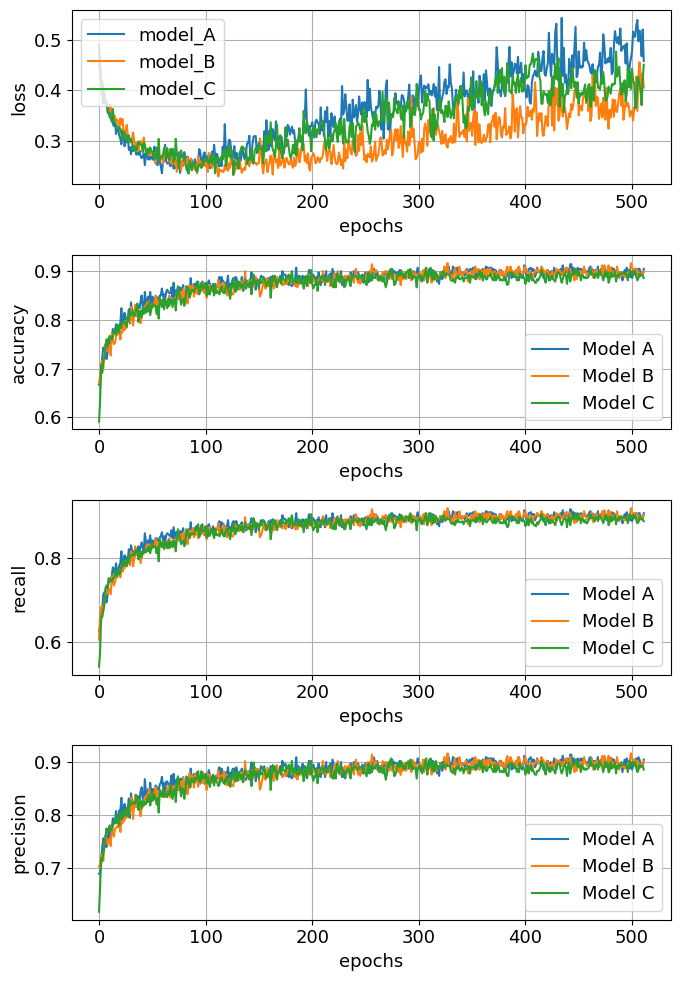

,metrics.val_accuracy,metrics.val_loss,params.hid_layer_number,params.hid_layer_units
0,0.904988,0.458782,2,1024
1,0.900238,0.405601,2,512
2,0.885986,0.451250,3,256


In [17]:
# exp = mlflow.get_experiment(experiment_id=1)
models = 'A', 'B', 'C'
all_runs = mlflow.search_runs(experiment_names=[exp_name])

# filter out non-basemodel runs
best_model_runs = all_runs.where(all_runs['tags.mlflow.runName'].isin(["model_A", "model_B", "model_C"])).dropna(how='all')
metrics_of_interest = ['accuracy', "recall", "precision", 'val_accuracy', "val_recall", "val_precision", "loss", "val_loss"]

# accuracy
# plot best models

plt.figure(1, (7, 10), dpi=100)
for idx, run_id in enumerate(best_model_runs['run_id']):
    model_name = all_runs['tags.mlflow.runName'].where(all_runs['run_id'].isin([run_id])).dropna(how='all')

    plt.subplot(4, 1, 1)
    plt.plot(get_metric(run_id=run_id, metric='val_loss'), label=model_name)
    plt.xlabel('epochs')
    plt.ylabel('loss')
    plt.legend()
    plt.grid()

    plt.subplot(4, 1, 2)
    plt.plot(get_metric(run_id=run_id, metric='val_accuracy'), label=f"Model {models[idx]}")
    plt.xlabel('epochs')
    plt.ylabel('accuracy')
    plt.legend()
    plt.grid()

    plt.subplot(4, 1, 3)
    plt.plot(get_metric(run_id=run_id, metric='val_recall'), label=f"Model {models[idx]}")
    plt.xlabel('epochs')
    plt.ylabel('recall')
    plt.legend()
    plt.grid()

    plt.subplot(4, 1, 4)
    plt.plot(get_metric(run_id=run_id, metric='val_precision'), label=f"Model {models[idx]}")
    plt.xlabel('epochs')
    plt.ylabel('precision')
    plt.legend()
    plt.grid()


plt.tight_layout()
plt.savefig("report/assets/hyper_param_best_models_final")
plt.show()


In [19]:

best_model_runs[[
    'tags.mlflow.runName',
    'metrics.val_accuracy',
    'metrics.val_loss',
    'params.hid_layer_number',
    'params.hid_layer_units',
]].to_numpy()

array([['model_A', 0.9049881100654602, 0.45878198742866516, '2', '1024'],
       ['model_B', 0.900237500667572, 0.4056008756160736, '2', '512'],
       ['model_C', 0.8859857320785522, 0.4512504041194916, '3', '256']],
      dtype=object)

## Comparison Between RProp, SGD and Hybrid

### Reload Data

In [2]:
########################################
## data
########################################
k_folds_num = 8
training_dataset_name = 'df__filled__means'
total_data__dict = {training_dataset_name: {}}
for k in range(k_folds_num):
    total_data__dict[training_dataset_name][f'k_fold_train_{k}'] = pd.read_csv(f"./data/{training_dataset_name}/k_fold_train_{k}.csv")
    total_data__dict[training_dataset_name][f'k_fold_valid_{k}'] = pd.read_csv(f"./data/{training_dataset_name}/k_fold_valid_{k}.csv")


### Learning Algorithms

---
Algorithms in question with their parameters:

- RProp
    - parameters
        - no parameters (use from paper)
- SGD
    - parameters:
        - learning_rate
        - momentum

---
Hybrid of the two:
- Hybrid
    - Averages from:
        - RProp
        - SGD (optimised inputs from individual study.)
    - parameters
        - gamma_rprop
        - gamma_sgd (The weights of the specific algorithm)
---
Optional
- Adam (extra)
    - parameters
        - learning_rate
        - beta_1 (The exponential decay rate for the 1st moment estimates.)
        - beta_2 (The exponential decay rate for the 2nd moment estimates.)
        - epsilon (A small constant for numerical stability. This epsilon is "epsilon hat" in the Kingma_2014)

---

### Setup

In [19]:
#############################################################
## static parameters 
#############################################################
inp_layer_units = 12
out_layer_units = 3
dropout_seed = 24
#######################

comb_loss = ['binary_crossentropy']
comb_hid_layer_units = [int(2**9)]
comb_hid_layer_number= [2]
comb_activation_func = ['relu']
comb_epochs = [int(2**9)]
comb_dropout_rate = [0.2]


activation_func = comb_activation_func[0]
loss_func       = comb_loss[0]
epochs = comb_epochs[0]
dropout_rate = comb_dropout_rate[0]

class AveragingCallback(tf.keras.callbacks.Callback):
    def __init__(self, k_folds, metrics):
        super().__init__()
        self.k_folds = k_folds
        self.metrics = metrics + ['loss']
        self.current_fold = 0
        self.sum_metrics = {m: np.zeros(epochs) for m in self.metrics + [f'val_{m}' for m in self.metrics]}
        self.parent_run_id = None

    def set_parent_run_id(self, run_id):
        self.parent_run_id = run_id

    def on_train_begin(self, logs=None):
        self.current_fold += 1

    def on_epoch_end(self, epoch, logs=None):
        for metric in self.metrics:
            if len(self.sum_metrics[metric]) <= epoch:
                self.sum_metrics[metric].append(0)
                self.sum_metrics[f'val_{metric}'].append(0)
            
            self.sum_metrics[metric][epoch] += logs.get(metric, 0)
            self.sum_metrics[f'val_{metric}'][epoch] += logs.get(f'val_{metric}', 0)
        
        # Calculate and log running averages
        if self.current_fold == self.k_folds:
            for metric in self.metrics:
                avg_train = self.sum_metrics[metric][epoch] / self.k_folds
                avg_val = self.sum_metrics[f'val_{metric}'][epoch] / self.k_folds
                mlflow.log_metric(f"{metric}", avg_train, step=epoch, run_id=self.parent_run_id)
                mlflow.log_metric(f"val_{metric}", avg_val, step=epoch, run_id=self.parent_run_id)

    def on_train_end(self, logs=None):
        if self.current_fold == self.k_folds:
            # Log final averages
            for metric in self.metrics:
                final_avg_train = np.mean(self.sum_metrics[metric] / self.k_folds)
                final_avg_val = np.mean(self.sum_metrics[f'val_{metric}'] / self.k_folds)
                # mlflow.log_metric(f"final_avg_{metric}", final_avg_train, run_id=self.parent_run_id)
                mlflow.log_metric(f"validation_{metric}", final_avg_val, run_id=self.parent_run_id)


################################
## helper functions
################################
def generate_ml_run_name(word_length=3, num_words=2):
    """
    Generate a random short name for ML runs.
    
    Args:
    word_length (int): Length of each word in the name. Default is 3.
    num_words (int): Number of words in the name. Default is 2.
    
    Returns:
    str: A randomly generated name for an ML run.
    """
    consonants = 'bcdfghjklmnpqrstvwxyz'
    vowels = 'aeiou'
    
    def generate_word():
        word = ''
        for i in range(word_length):
            if i % 2 == 0:
                word += random.choice(consonants)
            else:
                word += random.choice(vowels)
        return word
    
    words = [generate_word() for _ in range(num_words)]
    return '_'.join(words)


def create_tf_dataset(X, y, batch_size=32, shuffle=True, prefetch=True):
    dataset = tf.data.Dataset.from_tensor_slices((X.values, y.values))
    
    if shuffle:
        dataset = dataset.shuffle(buffer_size=len(X))
    
    dataset = dataset.batch(batch_size)
    
    if prefetch:
        dataset = dataset.prefetch(tf.data.AUTOTUNE)
    
    return dataset


def average_metrics(metrics_list):
    return {k: np.mean([d[k] for d in metrics_list]) for k in metrics_list[0]}


def get_metric(run_id: str, metric: str) -> np.ndarray:
    client = mlflow.tracking.MlflowClient()
    list_metric_hist = client.get_metric_history(run_id=run_id, key=metric)
    return np.array([
        m.value for m in list_metric_hist
    ])

#####
%env MLFLOW_TRACKING_URI=sqlite:///mlruns.db
exp_name = 'cos711_ass_2__optimisers_study_v1'
mlflow.set_experiment(exp_name)
logger = logging.getLogger("mlflow")
# Set log level to DEBUG
logger.setLevel(logging.ERROR)

env: MLFLOW_TRACKING_URI=sqlite:///mlruns.db


2024/10/04 22:00:15 INFO mlflow.store.db.utils: Creating initial MLflow database tables...
2024/10/04 22:00:15 INFO mlflow.store.db.utils: Updating database tables
INFO  [alembic.runtime.migration] Context impl SQLiteImpl.
INFO  [alembic.runtime.migration] Will assume non-transactional DDL.
INFO  [alembic.runtime.migration] Context impl SQLiteImpl.
INFO  [alembic.runtime.migration] Will assume non-transactional DDL.


### Helper Functions

In [13]:
def generate_ml_run_name(word_length=3, num_words=2):
    """
    Generate a random short name for ML runs.
    
    Args:
    word_length (int): Length of each word in the name. Default is 3.
    num_words (int): Number of words in the name. Default is 2.
    
    Returns:
    str: A randomly generated name for an ML run.
    """
    consonants = 'bcdfghjklmnpqrstvwxyz'
    vowels = 'aeiou'
    
    def generate_word():
        word = ''
        for i in range(word_length):
            if i % 2 == 0:
                word += random.choice(consonants)
            else:
                word += random.choice(vowels)
        return word
    
    words = [generate_word() for _ in range(num_words)]
    return '_'.join(words)


def create_tf_dataset(X, y, batch_size=32, shuffle=True, prefetch=True):
    dataset = tf.data.Dataset.from_tensor_slices((X.values, y.values))
    
    if shuffle:
        dataset = dataset.shuffle(buffer_size=len(X))
    
    dataset = dataset.batch(batch_size)
    
    if prefetch:
        dataset = dataset.prefetch(tf.data.AUTOTUNE)
    
    return dataset



def get_metric(run_id: str, metric: str) -> np.ndarray:
    client = mlflow.tracking.MlflowClient()
    list_metric_hist = client.get_metric_history(run_id=run_id, key=metric)
    return np.array([
        m.value for m in list_metric_hist
    ])


class AveragingCallback(tf.keras.callbacks.Callback):
    def __init__(self, k_folds, metrics):
        super().__init__()
        self.k_folds = k_folds
        self.metrics = metrics + ['loss']
        self.current_fold = 0
        self.sum_metrics = {m: np.zeros(epochs) for m in self.metrics + [f'val_{m}' for m in self.metrics]}
        self.parent_run_id = None

    def set_parent_run_id(self, run_id):
        self.parent_run_id = run_id

    def on_train_begin(self, logs=None):
        self.current_fold += 1

    def on_epoch_end(self, epoch, logs=None):
        for metric in self.metrics:
            if len(self.sum_metrics[metric]) <= epoch:
                self.sum_metrics[metric].append(0)
                self.sum_metrics[f'val_{metric}'].append(0)
            
            self.sum_metrics[metric][epoch] += logs.get(metric, 0)
            self.sum_metrics[f'val_{metric}'][epoch] += logs.get(f'val_{metric}', 0)
        
        # Calculate and log running averages
        if self.current_fold == self.k_folds:
            for metric in self.metrics:
                avg_train = self.sum_metrics[metric][epoch] / self.k_folds
                avg_val = self.sum_metrics[f'val_{metric}'][epoch] / self.k_folds
                mlflow.log_metric(f"{metric}", avg_train, step=epoch, run_id=self.parent_run_id)
                mlflow.log_metric(f"val_{metric}", avg_val, step=epoch, run_id=self.parent_run_id)

    def on_train_end(self, logs=None):
        if self.current_fold == self.k_folds:
            # Log final averages
            for metric in self.metrics:
                final_avg_train = np.mean(self.sum_metrics[metric] / self.k_folds)
                final_avg_val = np.mean(self.sum_metrics[f'val_{metric}'] / self.k_folds)
                # mlflow.log_metric(f"final_avg_{metric}", final_avg_train, run_id=self.parent_run_id)
                mlflow.log_metric(f"validation_{metric}", final_avg_val, run_id=self.parent_run_id)

def average_metrics(metrics_list):
    return {k: np.mean([d[k] for d in metrics_list]) for k in metrics_list[0]}


### Train - RProp

In [ ]:
from keras.src.optimizers import optimizer
from keras.src import ops

class RProp(optimizer.Optimizer):
    """Resilient Propagation (RProp) optimizer.

    RProp is a first-order optimization algorithm that adapts the step size
    for each weight individually based on the sign of the gradient.

    The update rule for RProp is as follows:

    ```python
    if grad * prev_grad > 0:
        delta = min(delta * eta_plus, delta_max)
    elif grad * prev_grad < 0:
        delta = max(delta * eta_minus, delta_min)
        grad = 0  # Set gradient to zero to revert the previous step
    
    w = w - sign(grad) * delta
    prev_grad = grad
    ```

    Args:
        initial_learning_rate: A float, initial learning rate (step size).
            Defaults to 0.1.
        eta_plus: Factor to increase step size. Defaults to 1.2.
        eta_minus: Factor to decrease step size. Defaults to 0.5.
        delta_min: Minimum step size. Defaults to 1e-6.
        delta_max: Maximum step size. Defaults to 50.0.
    """

    def __init__(
        self,
        initial_learning_rate=0.1,
        eta_plus=1.2,
        eta_minus=0.5,
        delta_min=1e-6,
        delta_max=50.0,
        weight_decay=None,
        clipnorm=None,
        clipvalue=None,
        global_clipnorm=None,
        use_ema=False,
        ema_momentum=0.99,
        ema_overwrite_frequency=None,
        name="RProp",
        **kwargs,
    ):
        super().__init__(
            name=name,
            learning_rate=initial_learning_rate,
            weight_decay=weight_decay,
            clipnorm=clipnorm,
            clipvalue=clipvalue,
            global_clipnorm=global_clipnorm,
            use_ema=use_ema,
            ema_momentum=ema_momentum,
            ema_overwrite_frequency=ema_overwrite_frequency,
            **kwargs,
        )
        self.initial_learning_rate = initial_learning_rate
        self.eta_plus = eta_plus
        self.eta_minus = eta_minus
        self.delta_min = delta_min
        self.delta_max = delta_max

    def build(self, variables):
        """Initialize optimizer variables."""
        if self.built:
            return
        super().build(variables)
        self.deltas = []
        self.prev_grads = []
        for variable in variables:
            self.deltas.append(
                self.add_variable_from_reference(
                    reference_variable=variable, 
                    name="delta",
                    # initializer=initial_learning_rate
                )
            )
            self.prev_grads.append(
                self.add_variable_from_reference(
                    reference_variable=variable, 
                    name="prev_grad",
                    # initializer=0
                )
            )

    def update_step(self, gradient, variable, learning_rate):
        """Update step given gradient and the associated model variable."""
        var_dtype = variable.dtype
        grad = ops.cast(gradient, var_dtype)
        
        var_index = self._get_variable_index(variable)
        delta = self.deltas[var_index]
        prev_grad = self.prev_grads[var_index]

        grad_prod = ops.multiply(grad, prev_grad)
        
        # Update delta
        delta_t = ops.where(
            ops.greater(grad_prod, 0),
            ops.minimum(ops.multiply(delta, self.eta_plus), self.delta_max),
            ops.where(
                ops.less(grad_prod, 0),
                ops.maximum(ops.multiply(delta, self.eta_minus), self.delta_min),
                delta
            )
        )
        self.assign(delta, delta_t)

        # Update variable
        grad_sign = ops.sign(grad)
        self.assign_sub(variable, ops.multiply(grad_sign, delta_t))

        # Update previous gradient
        grad_t = ops.where(ops.less(grad_prod, 0), ops.zeros_like(grad), grad)
        self.assign(prev_grad, grad_t)

    def get_config(self):
        config = super().get_config()
        config.update({
            "initial_learning_rate": self.initial_learning_rate,
            "eta_plus": self.eta_plus,
            "eta_minus": self.eta_minus,
            "delta_min": self.delta_min,
            "delta_max": self.delta_max,
        })
        return config

In [107]:
feature_list = [
    'length_major_axis',
    'width_minor_axis',
    'thickness_depth',
    'area',
    'perimeter', 'roundness',
    'solidity',
    'compactness',
    'aspect_ratio',
    'eccentricity',
    'extent',
    'convex_hull_convex_area'
]
target_list = ['almond_type_MAMRA', 'almond_type_REGULAR', 'almond_type_SANORA']
metrics = ['accuracy', "recall", "precision"]
hid_layer_unit = comb_hid_layer_units[0]
hid_layer_number = comb_hid_layer_number[0]
k_folds = 8
learning_rate = 0.1

#################
## setup model
#################
input_layer = [tf.keras.layers.Input(shape=(inp_layer_units,), name='input_layer')]
output_layer = [tf.keras.layers.Dense(units=out_layer_units, activation='softmax', name='output_layer')]
hidden_layers = []
for idx in range(hid_layer_number):
    hidden_layers.append(
        tf.keras.layers.Dense(units=hid_layer_unit, activation=activation_func, name=f'hidden_layer__{idx}')
    )
    hidden_layers.append(
        tf.keras.layers.Dropout(rate=dropout_rate, seed=dropout_seed, name=f"dropout_layer__{idx}")
    )
base_model_name = "RProp_model"  # generate_ml_run_name(4, 2)

model_base = tf.keras.Sequential(
    layers=input_layer+hidden_layers+output_layer,
    name=base_model_name
)

##################
## training
##################
flow_name__main = base_model_name
with mlflow.start_run(run_name=flow_name__main) as parent_run:
    parent_run_id = parent_run.info.run_id


    averaging_callback = AveragingCallback(k_folds, metrics)
    averaging_callback.set_parent_run_id(parent_run_id)

    # Total training
    dataset = "df__filled__means"
        
    for k in range(k_folds):
        flow_name = f"{flow_name__main}__k{k}"
        
        with mlflow.start_run(run_name=flow_name, nested=True) as child_run:
            optimiser  = RProp(initial_learning_rate=learning_rate)

            model = tf.keras.models.clone_model(model_base)
            model.compile(optimizer=optimiser, loss=loss_func, metrics=metrics)

            training_set = total_data__dict[dataset][f'k_fold_train_{k}']
            validating_set = total_data__dict[dataset][f'k_fold_valid_{k}']

            X_train, y_train = training_set[feature_list], training_set[target_list]
            X_valid, y_valid = validating_set[feature_list], validating_set[target_list]

            batch_size = 32  # Adjust this value based on your needs
            train_dataset = create_tf_dataset(X_train, y_train, batch_size=batch_size)
            valid_dataset = create_tf_dataset(X_valid, y_valid, batch_size=batch_size, shuffle=False)

            k_fold_hist = model.fit(
                train_dataset,
                validation_data=valid_dataset,
                epochs=epochs,
                callbacks=[mlflow.keras.MlflowCallback(), averaging_callback],
                verbose=0
            )
            params = {
                "loss" : loss_func,
                "optimiser": optimiser.name,
                "hid_layer_unit" : hid_layer_unit,
                "hid_layer_number" : hid_layer_number,
                "activation_func" : activation_func,
                "learning_rate" : learning_rate,
                "epochs" : epochs,
                "dropout_rate" : dropout_rate,
                "df__fill_type": dataset
            }
            
            # Log parameters
            mlflow.log_params(params)
        

Tensor("RProp_1/IdentityN:0", shape=(12, 512), dtype=float32) <tf.Variable 'RProp_model/hidden_layer__0/kernel:0' shape=(12, 512) dtype=float32> <KerasVariable shape=(), dtype=float32, path=RProp/learning_rate>
Tensor("RProp_1/IdentityN:1", shape=(512,), dtype=float32) <tf.Variable 'RProp_model/hidden_layer__0/bias:0' shape=(512,) dtype=float32> <KerasVariable shape=(), dtype=float32, path=RProp/learning_rate>
Tensor("RProp_1/IdentityN:2", shape=(512, 512), dtype=float32) <tf.Variable 'RProp_model/hidden_layer__1/kernel:0' shape=(512, 512) dtype=float32> <KerasVariable shape=(), dtype=float32, path=RProp/learning_rate>
Tensor("RProp_1/IdentityN:3", shape=(512,), dtype=float32) <tf.Variable 'RProp_model/hidden_layer__1/bias:0' shape=(512,) dtype=float32> <KerasVariable shape=(), dtype=float32, path=RProp/learning_rate>
Tensor("RProp_1/IdentityN:4", shape=(512, 3), dtype=float32) <tf.Variable 'RProp_model/output_layer/kernel:0' shape=(512, 3) dtype=float32> <KerasVariable shape=(), dtype

Tensor("RProp_1/IdentityN:0", shape=(12, 512), dtype=float32) <tf.Variable 'RProp_model/hidden_layer__0/kernel:0' shape=(12, 512) dtype=float32> <KerasVariable shape=(), dtype=float32, path=RProp/learning_rate>
Tensor("RProp_1/IdentityN:1", shape=(512,), dtype=float32) <tf.Variable 'RProp_model/hidden_layer__0/bias:0' shape=(512,) dtype=float32> <KerasVariable shape=(), dtype=float32, path=RProp/learning_rate>
Tensor("RProp_1/IdentityN:2", shape=(512, 512), dtype=float32) <tf.Variable 'RProp_model/hidden_layer__1/kernel:0' shape=(512, 512) dtype=float32> <KerasVariable shape=(), dtype=float32, path=RProp/learning_rate>
Tensor("RProp_1/IdentityN:3", shape=(512,), dtype=float32) <tf.Variable 'RProp_model/hidden_layer__1/bias:0' shape=(512,) dtype=float32> <KerasVariable shape=(), dtype=float32, path=RProp/learning_rate>
Tensor("RProp_1/IdentityN:4", shape=(512, 3), dtype=float32) <tf.Variable 'RProp_model/output_layer/kernel:0' shape=(512, 3) dtype=float32> <KerasVariable shape=(), dtype

Tensor("RProp_1/IdentityN:0", shape=(12, 512), dtype=float32) <tf.Variable 'RProp_model/hidden_layer__0/kernel:0' shape=(12, 512) dtype=float32> <KerasVariable shape=(), dtype=float32, path=RProp/learning_rate>
Tensor("RProp_1/IdentityN:1", shape=(512,), dtype=float32) <tf.Variable 'RProp_model/hidden_layer__0/bias:0' shape=(512,) dtype=float32> <KerasVariable shape=(), dtype=float32, path=RProp/learning_rate>
Tensor("RProp_1/IdentityN:2", shape=(512, 512), dtype=float32) <tf.Variable 'RProp_model/hidden_layer__1/kernel:0' shape=(512, 512) dtype=float32> <KerasVariable shape=(), dtype=float32, path=RProp/learning_rate>
Tensor("RProp_1/IdentityN:3", shape=(512,), dtype=float32) <tf.Variable 'RProp_model/hidden_layer__1/bias:0' shape=(512,) dtype=float32> <KerasVariable shape=(), dtype=float32, path=RProp/learning_rate>
Tensor("RProp_1/IdentityN:4", shape=(512, 3), dtype=float32) <tf.Variable 'RProp_model/output_layer/kernel:0' shape=(512, 3) dtype=float32> <KerasVariable shape=(), dtype

Tensor("RProp_1/IdentityN:0", shape=(12, 512), dtype=float32) <tf.Variable 'RProp_model/hidden_layer__0/kernel:0' shape=(12, 512) dtype=float32> <KerasVariable shape=(), dtype=float32, path=RProp/learning_rate>
Tensor("RProp_1/IdentityN:1", shape=(512,), dtype=float32) <tf.Variable 'RProp_model/hidden_layer__0/bias:0' shape=(512,) dtype=float32> <KerasVariable shape=(), dtype=float32, path=RProp/learning_rate>
Tensor("RProp_1/IdentityN:2", shape=(512, 512), dtype=float32) <tf.Variable 'RProp_model/hidden_layer__1/kernel:0' shape=(512, 512) dtype=float32> <KerasVariable shape=(), dtype=float32, path=RProp/learning_rate>
Tensor("RProp_1/IdentityN:3", shape=(512,), dtype=float32) <tf.Variable 'RProp_model/hidden_layer__1/bias:0' shape=(512,) dtype=float32> <KerasVariable shape=(), dtype=float32, path=RProp/learning_rate>
Tensor("RProp_1/IdentityN:4", shape=(512, 3), dtype=float32) <tf.Variable 'RProp_model/output_layer/kernel:0' shape=(512, 3) dtype=float32> <KerasVariable shape=(), dtype

Tensor("RProp_1/IdentityN:0", shape=(12, 512), dtype=float32) <tf.Variable 'RProp_model/hidden_layer__0/kernel:0' shape=(12, 512) dtype=float32> <KerasVariable shape=(), dtype=float32, path=RProp/learning_rate>
Tensor("RProp_1/IdentityN:1", shape=(512,), dtype=float32) <tf.Variable 'RProp_model/hidden_layer__0/bias:0' shape=(512,) dtype=float32> <KerasVariable shape=(), dtype=float32, path=RProp/learning_rate>
Tensor("RProp_1/IdentityN:2", shape=(512, 512), dtype=float32) <tf.Variable 'RProp_model/hidden_layer__1/kernel:0' shape=(512, 512) dtype=float32> <KerasVariable shape=(), dtype=float32, path=RProp/learning_rate>
Tensor("RProp_1/IdentityN:3", shape=(512,), dtype=float32) <tf.Variable 'RProp_model/hidden_layer__1/bias:0' shape=(512,) dtype=float32> <KerasVariable shape=(), dtype=float32, path=RProp/learning_rate>
Tensor("RProp_1/IdentityN:4", shape=(512, 3), dtype=float32) <tf.Variable 'RProp_model/output_layer/kernel:0' shape=(512, 3) dtype=float32> <KerasVariable shape=(), dtype

Tensor("RProp_1/IdentityN:0", shape=(12, 512), dtype=float32) <tf.Variable 'RProp_model/hidden_layer__0/kernel:0' shape=(12, 512) dtype=float32> <KerasVariable shape=(), dtype=float32, path=RProp/learning_rate>
Tensor("RProp_1/IdentityN:1", shape=(512,), dtype=float32) <tf.Variable 'RProp_model/hidden_layer__0/bias:0' shape=(512,) dtype=float32> <KerasVariable shape=(), dtype=float32, path=RProp/learning_rate>
Tensor("RProp_1/IdentityN:2", shape=(512, 512), dtype=float32) <tf.Variable 'RProp_model/hidden_layer__1/kernel:0' shape=(512, 512) dtype=float32> <KerasVariable shape=(), dtype=float32, path=RProp/learning_rate>
Tensor("RProp_1/IdentityN:3", shape=(512,), dtype=float32) <tf.Variable 'RProp_model/hidden_layer__1/bias:0' shape=(512,) dtype=float32> <KerasVariable shape=(), dtype=float32, path=RProp/learning_rate>
Tensor("RProp_1/IdentityN:4", shape=(512, 3), dtype=float32) <tf.Variable 'RProp_model/output_layer/kernel:0' shape=(512, 3) dtype=float32> <KerasVariable shape=(), dtype

Tensor("RProp_1/IdentityN:0", shape=(12, 512), dtype=float32) <tf.Variable 'RProp_model/hidden_layer__0/kernel:0' shape=(12, 512) dtype=float32> <KerasVariable shape=(), dtype=float32, path=RProp/learning_rate>
Tensor("RProp_1/IdentityN:1", shape=(512,), dtype=float32) <tf.Variable 'RProp_model/hidden_layer__0/bias:0' shape=(512,) dtype=float32> <KerasVariable shape=(), dtype=float32, path=RProp/learning_rate>
Tensor("RProp_1/IdentityN:2", shape=(512, 512), dtype=float32) <tf.Variable 'RProp_model/hidden_layer__1/kernel:0' shape=(512, 512) dtype=float32> <KerasVariable shape=(), dtype=float32, path=RProp/learning_rate>
Tensor("RProp_1/IdentityN:3", shape=(512,), dtype=float32) <tf.Variable 'RProp_model/hidden_layer__1/bias:0' shape=(512,) dtype=float32> <KerasVariable shape=(), dtype=float32, path=RProp/learning_rate>
Tensor("RProp_1/IdentityN:4", shape=(512, 3), dtype=float32) <tf.Variable 'RProp_model/output_layer/kernel:0' shape=(512, 3) dtype=float32> <KerasVariable shape=(), dtype

Tensor("RProp_1/IdentityN:0", shape=(12, 512), dtype=float32) <tf.Variable 'RProp_model/hidden_layer__0/kernel:0' shape=(12, 512) dtype=float32> <KerasVariable shape=(), dtype=float32, path=RProp/learning_rate>
Tensor("RProp_1/IdentityN:1", shape=(512,), dtype=float32) <tf.Variable 'RProp_model/hidden_layer__0/bias:0' shape=(512,) dtype=float32> <KerasVariable shape=(), dtype=float32, path=RProp/learning_rate>
Tensor("RProp_1/IdentityN:2", shape=(512, 512), dtype=float32) <tf.Variable 'RProp_model/hidden_layer__1/kernel:0' shape=(512, 512) dtype=float32> <KerasVariable shape=(), dtype=float32, path=RProp/learning_rate>
Tensor("RProp_1/IdentityN:3", shape=(512,), dtype=float32) <tf.Variable 'RProp_model/hidden_layer__1/bias:0' shape=(512,) dtype=float32> <KerasVariable shape=(), dtype=float32, path=RProp/learning_rate>
Tensor("RProp_1/IdentityN:4", shape=(512, 3), dtype=float32) <tf.Variable 'RProp_model/output_layer/kernel:0' shape=(512, 3) dtype=float32> <KerasVariable shape=(), dtype

### Train - SGD 

In [112]:
feature_list = [
    'length_major_axis',
    'width_minor_axis',
    'thickness_depth',
    'area',
    'perimeter', 'roundness',
    'solidity',
    'compactness',
    'aspect_ratio',
    'eccentricity',
    'extent',
    'convex_hull_convex_area'
]
target_list = ['almond_type_MAMRA', 'almond_type_REGULAR', 'almond_type_SANORA']
metrics = ['accuracy', "recall", "precision"]
hid_layer_unit = comb_hid_layer_units[0]
hid_layer_number = comb_hid_layer_number[0]

#################
## setup model
#################
input_layer = [tf.keras.layers.Input(shape=(inp_layer_units,), name='input_layer')]
output_layer = [tf.keras.layers.Dense(units=out_layer_units, activation='softmax', name='output_layer')]
hidden_layers = []
for idx in range(hid_layer_number):
    hidden_layers.append(
        tf.keras.layers.Dense(units=hid_layer_unit, activation=activation_func, name=f'hidden_layer__{idx}')
    )
    hidden_layers.append(
        tf.keras.layers.Dropout(rate=dropout_rate, seed=dropout_seed, name=f"dropout_layer__{idx}")
    )
base_model_name = "SGD_model"  # generate_ml_run_name(4, 2)

model_base = tf.keras.Sequential(
    layers=input_layer+hidden_layers+output_layer,
    name=base_model_name
)

##################
## training
##################
flow_name__main = base_model_name+"__"+generate_ml_run_name(4, 1)
for lr in learning_rates:
    for momentum in momentum_ratios:
        with mlflow.start_run(run_name=flow_name__main) as parent_run:
            parent_run_id = parent_run.info.run_id


            averaging_callback = AveragingCallback(k_folds, metrics)
            averaging_callback.set_parent_run_id(parent_run_id)

            # Total training
            dataset = "df__filled__means"
                
            for k in range(k_folds):
                flow_name = f"{flow_name__main}__k{k}"
                
                with mlflow.start_run(run_name=flow_name, nested=True) as child_run:
                    optimiser  = tf.keras.optimizers.SGD(learning_rate=lr, momentum=momentum)

                    model = tf.keras.models.clone_model(model_base)
                    model.compile(optimizer=optimiser, loss=loss_func, metrics=metrics)

                    training_set = total_data__dict[dataset][f'k_fold_train_{k}']
                    validating_set = total_data__dict[dataset][f'k_fold_valid_{k}']

                    X_train, y_train = training_set[feature_list], training_set[target_list]
                    X_valid, y_valid = validating_set[feature_list], validating_set[target_list]

                    batch_size = 32  # Adjust this value based on your needs
                    train_dataset = create_tf_dataset(X_train, y_train, batch_size=batch_size)
                    valid_dataset = create_tf_dataset(X_valid, y_valid, batch_size=batch_size, shuffle=False)

                    k_fold_hist = model.fit(
                        train_dataset,
                        validation_data=valid_dataset,
                        epochs=epochs,
                        callbacks=[mlflow.keras.MlflowCallback(), averaging_callback],
                        verbose=0
                    )
                    params = {
                        "loss" : loss_func,
                        "optimiser": 'sgd',
                        "hid_layer_unit" : hid_layer_unit,
                        "hid_layer_number" : hid_layer_number,
                        "activation_func" : activation_func,
                        "learning_rate" : learning_rate,
                        "epochs" : epochs,
                        "dropout_rate" : dropout_rate,
                        "df__fill_type": dataset
                    }
                    
                    # Log parameters
                    mlflow.log_params(params, run_id=child_run.info.run_id)
            mlflow.log_params(params, run_id=parent_run_id)
        

KeyboardInterrupt: 

### Train - Adam

In [ ]:

feature_list = [
    'length_major_axis',
    'width_minor_axis',
    'thickness_depth',
    'area',
    'perimeter', 'roundness',
    'solidity',
    'compactness',
    'aspect_ratio',
    'eccentricity',
    'extent',
    'convex_hull_convex_area'
]
target_list = ['almond_type_MAMRA', 'almond_type_REGULAR', 'almond_type_SANORA']
metrics = ['accuracy', "recall", "precision"]
hid_layer_unit = comb_hid_layer_units[0]
hid_layer_number = comb_hid_layer_number[0]
k_folds = 8
learning_rates = [0.032, 0.01, 0.0032, 0.001]
momentum_ratios = [0.01*m for m in range(1, 11)]

#################
## setup model
#################
input_layer = [tf.keras.layers.Input(shape=(inp_layer_units,), name='input_layer')]
output_layer = [tf.keras.layers.Dense(units=out_layer_units, activation='softmax', name='output_layer')]
hidden_layers = []
for idx in range(hid_layer_number):
    hidden_layers.append(
        tf.keras.layers.Dense(units=hid_layer_unit, activation=activation_func, name=f'hidden_layer__{idx}')
    )
    hidden_layers.append(
        tf.keras.layers.Dropout(rate=dropout_rate, seed=dropout_seed, name=f"dropout_layer__{idx}")
    )
base_model_name = "ADAM_model"  # generate_ml_run_name(4, 2)

model_base = tf.keras.Sequential(
    layers=input_layer+hidden_layers+output_layer,
    name=base_model_name
)

##################
## training
##################
flow_name__main = base_model_name+"__"+generate_ml_run_name(4, 1)
for lr in learning_rates:
    for momentum in momentum_ratios:
        with mlflow.start_run(run_name=flow_name__main) as parent_run:
            parent_run_id = parent_run.info.run_id


            averaging_callback = AveragingCallback(k_folds, metrics)
            averaging_callback.set_parent_run_id(parent_run_id)

            # Total training
            dataset = "df__filled__means"
                
            for k in range(k_folds):
                flow_name = f"{flow_name__main}__k{k}"
                
                with mlflow.start_run(run_name=flow_name, nested=True) as child_run:
                    optimiser  = tf.keras.optimizers.Adam(learning_rate=lr, beta_1=momentum)

                    model = tf.keras.models.clone_model(model_base)
                    model.compile(optimizer=optimiser, loss=loss_func, metrics=metrics)

                    training_set = total_data__dict[dataset][f'k_fold_train_{k}']
                    validating_set = total_data__dict[dataset][f'k_fold_valid_{k}']

                    X_train, y_train = training_set[feature_list], training_set[target_list]
                    X_valid, y_valid = validating_set[feature_list], validating_set[target_list]

                    batch_size = 32  # Adjust this value based on your needs
                    train_dataset = create_tf_dataset(X_train, y_train, batch_size=batch_size)
                    valid_dataset = create_tf_dataset(X_valid, y_valid, batch_size=batch_size, shuffle=False)

                    k_fold_hist = model.fit(
                        train_dataset,
                        validation_data=valid_dataset,
                        epochs=epochs,
                        callbacks=[mlflow.keras.MlflowCallback(), averaging_callback],
                        verbose=0
                    )
                    params = {
                        "loss" : loss_func,
                        "optimiser": 'sgd',
                        "hid_layer_unit" : hid_layer_unit,
                        "hid_layer_number" : hid_layer_number,
                        "activation_func" : activation_func,
                        "learning_rate" : learning_rate,
                        "epochs" : epochs,
                        "dropout_rate" : dropout_rate,
                        "df__fill_type": dataset
                    }
                    
                    # Log parameters
                    mlflow.log_params(params, run_id=child_run.info.run_id)
            mlflow.log_params(params, run_id=parent_run_id)
        

### Train - Hybrid

In [38]:
from keras.src.optimizers import optimizer
from keras.src import ops

class HybridOpt(optimizer.Optimizer):
    """Hybrid optimizer combining SGD and Adam.

    This optimizer implements a novel hybrid method that combines
    Stochastic Gradient Descent (SGD) and Adam optimizers.

    The update rule for HybridOpt is as follows:

    ```python
    # Adam part
    m_t = beta_1 * m + (1 - beta_1) * grad
    v_t = beta_2 * v + (1 - beta_2) * grad^2
    adam_update = alpha * m_t / (sqrt(v_t) + epsilon)

    # SGD part
    velocity_t = mu * velocity - eta * grad
    sgd_update = velocity_t

    # Hybrid update
    hybrid_update = learning_rate * (gamma * sgd_update + (1 - gamma) * adam_update)
    
    w = w + hybrid_update
    ```

    Args:
        learning_rate: A float, overall learning rate. Defaults to 0.001.
        gamma: A float, weight for the SGD component. Defaults to 0.5.
        alpha: Adam learning rate. Defaults to 0.001.
        beta_1: Adam exponential decay rate for first moment estimates. Defaults to 0.99.
        beta_2: Adam exponential decay rate for second moment estimates. Defaults to 0.09.
        epsilon: A small constant for numerical stability. Defaults to 1e-8.
        eta: SGD learning rate. Defaults to 0.001.
        mu: SGD momentum. Defaults to 0.04.
    """

    def __init__(
        self,
        learning_rate=0.001,
        gamma=0.5,
        alpha=0.001,
        beta_1=0.99,
        beta_2=0.09,
        epsilon=1e-8,
        eta=0.001,
        mu=0.04,
        weight_decay=None,
        clipnorm=None,
        clipvalue=None,
        global_clipnorm=None,
        use_ema=False,
        ema_momentum=0.99,
        ema_overwrite_frequency=None,
        name="HybridOpt",
        **kwargs,
    ):
        super().__init__(
            name=name,
            learning_rate=learning_rate,
            weight_decay=weight_decay,
            clipnorm=clipnorm,
            clipvalue=clipvalue,
            global_clipnorm=global_clipnorm,
            use_ema=use_ema,
            ema_momentum=ema_momentum,
            ema_overwrite_frequency=ema_overwrite_frequency,
            **kwargs,
        )
        self.gamma = gamma
        self.alpha = alpha
        self.beta_1 = beta_1
        self.beta_2 = beta_2
        self.epsilon = epsilon
        self.eta = eta
        self.mu = mu

    def build(self, variables):
        """Initialize optimizer variables."""
        if self.built:
            return
        super().build(variables)
        self.m = []
        self.v = []
        self.velocity = []
        for variable in variables:
            self.m.append(
                self.add_variable_from_reference(
                    reference_variable=variable, 
                    name="m"
                )
            )
            self.v.append(
                self.add_variable_from_reference(
                    reference_variable=variable, 
                    name="v"
                )
            )
            self.velocity.append(
                self.add_variable_from_reference(
                    reference_variable=variable, 
                    name="velocity"
                )
            )

    def update_step(self, gradient, variable, learning_rate=None):
        """Update step given gradient and the associated model variable."""
        var_dtype = variable.dtype
        grad = ops.cast(gradient, var_dtype)
        
        var_index = self._get_variable_index(variable)
        m = self.m[var_index]
        v = self.v[var_index]
        velocity = self.velocity[var_index]

        lr = self.learning_rate

        # Adam part
        m_t = self.beta_1 * m + (1 - self.beta_1) * grad
        v_t = self.beta_2 * v + (1 - self.beta_2) * ops.square(grad)
        adam_update = self.alpha * m_t / (ops.sqrt(v_t) + self.epsilon)

        # SGD part
        velocity_t = self.mu * velocity - self.eta * grad
        sgd_update = velocity_t

        # Hybrid update
        hybrid_update = lr * (self.gamma * sgd_update + (1 - self.gamma) * adam_update)

        self.assign_add(variable, hybrid_update)
        self.assign(m, m_t)
        self.assign(v, v_t)
        self.assign(velocity, velocity_t)

    def get_config(self):
        config = super().get_config()
        config.update({
            "gamma": self.gamma,
            "alpha": self.alpha,
            "beta_1": self.beta_1,
            "beta_2": self.beta_2,
            "epsilon": self.epsilon,
            "eta": self.eta,
            "mu": self.mu,
        })
        return config
    
hyb_opt = HybridOpt(learning_rate=0.1, gamma=0.5)

In [41]:
#############################################################
## static parameters 
#############################################################
inp_layer_units = 12
out_layer_units = 3
dropout_seed = 24
#######################

comb_loss = ['binary_crossentropy']
comb_hid_layer_units = [int(2**9)]
comb_hid_layer_number= [2]
comb_activation_func = ['relu']
comb_epochs = [int(2**9)]
comb_dropout_rate = [0.2]


activation_func = comb_activation_func[0]
loss_func       = comb_loss[0]
epochs = comb_epochs[0]
dropout_rate = comb_dropout_rate[0]


feature_list = [
    'length_major_axis',
    'width_minor_axis',
    'thickness_depth',
    'area',
    'perimeter', 'roundness',
    'solidity',
    'compactness',
    'aspect_ratio',
    'eccentricity',
    'extent',
    'convex_hull_convex_area'
]
target_list = ['almond_type_MAMRA', 'almond_type_REGULAR', 'almond_type_SANORA']
metrics = ['accuracy', "recall", "precision"]
hid_layer_unit = comb_hid_layer_units[0]
hid_layer_number = comb_hid_layer_number[0]
k_folds = 8
learning_rates = [0.032, 0.01, 0.0032, 0.001]
gamma_ratios = [0.1*m for m in range(1, 10)]
gamma_ratios = [0.5]
learning_rates = [1.]

#################
## setup model
#################
input_layer = [tf.keras.layers.Input(shape=(inp_layer_units,), name='input_layer')]
output_layer = [tf.keras.layers.Dense(units=out_layer_units, activation='softmax', name='output_layer')]
hidden_layers = []
for idx in range(hid_layer_number):
    hidden_layers.append(
        tf.keras.layers.Dense(units=hid_layer_unit, activation=activation_func, name=f'hidden_layer__{idx}')
    )
    hidden_layers.append(
        tf.keras.layers.Dropout(rate=dropout_rate, seed=dropout_seed, name=f"dropout_layer__{idx}")
    )
base_model_name = "Hybrid_model"  # generate_ml_run_name(4, 2)

model_base = tf.keras.Sequential(
    layers=input_layer+hidden_layers+output_layer,
    name=base_model_name
)

##################
## training
##################
flow_name__main = base_model_name+"__"+generate_ml_run_name(4, 1)
for lr in learning_rates:
    for gamma in gamma_ratios:
        with mlflow.start_run(run_name=flow_name__main) as parent_run:
            parent_run_id = parent_run.info.run_id
            dataset = "df__filled__means"


            averaging_callback = AveragingCallback(k_folds, metrics)
            averaging_callback.set_parent_run_id(parent_run_id)
            params = {
                "loss" : loss_func,
                "optimiser": 'Hybrid',
                "hid_layer_unit" : hid_layer_unit,
                "hid_layer_number" : hid_layer_number,
                "activation_func" : activation_func,
                "learning_rate" : lr,
                "gamma" : gamma,
                "epochs" : epochs,
                "dropout_rate" : dropout_rate,
                "df__fill_type": dataset
            }
            mlflow.log_params(params, run_id=parent_run_id)

            # Total training
                
            for k in range(k_folds):
                flow_name = f"{flow_name__main}__k{k}"
                
                with mlflow.start_run(run_name=flow_name, nested=True) as child_run:
                    optimiser  = HybridOpt(learning_rate=lr, gamma=gamma)
                    # Log parameters
                    mlflow.log_params(params, run_id=child_run.info.run_id)

                    model = tf.keras.models.clone_model(model_base)
                    model.compile(optimizer=optimiser, loss=loss_func, metrics=metrics)

                    training_set = total_data__dict[dataset][f'k_fold_train_{k}']
                    validating_set = total_data__dict[dataset][f'k_fold_valid_{k}']

                    X_train, y_train = training_set[feature_list], training_set[target_list]
                    X_valid, y_valid = validating_set[feature_list], validating_set[target_list]

                    batch_size = 32  # Adjust this value based on your needs
                    train_dataset = create_tf_dataset(X_train, y_train, batch_size=batch_size)
                    valid_dataset = create_tf_dataset(X_valid, y_valid, batch_size=batch_size, shuffle=False)

                    k_fold_hist = model.fit(
                        train_dataset,
                        validation_data=valid_dataset,
                        epochs=epochs,
                        callbacks=[mlflow.keras.MlflowCallback(), averaging_callback],
                        verbose=0
                    )
                    
        

KeyboardInterrupt: 

### Loss Landscapes

In [13]:
import sympy as sp
x1, x2, x3, x4 = sp.symbols('x1 x2 x3 x4')

# Quadratic function
print("\nQuadratic function")
quadratic_sp = (x1 + 2*x2 - 7)**2 + (2*x1 + x2 - 5)**2
d_quadratic_sp_d_x1 = sp.diff(quadratic_sp, x1)
d_quadratic_sp_d_x2 = sp.diff(quadratic_sp, x2)
print(d_quadratic_sp_d_x1)
print(d_quadratic_sp_d_x2)

# Powell's Quartic function
print("\nPowell's Quartic function")
powells_quartic_sp = (x1 + 10*x2)**2 + 5*(x3 - x4)**2 + (x2 - 2*x3)**4 + 10*(x1 - x4)**4
d_powells_quartic_sp_d_x1 = sp.diff(powells_quartic_sp, x1)
d_powells_quartic_sp_d_x2 = sp.diff(powells_quartic_sp, x2)
d_powells_quartic_sp_d_x3 = sp.diff(powells_quartic_sp, x3)
d_powells_quartic_sp_d_x4 = sp.diff(powells_quartic_sp, x4)
print(d_powells_quartic_sp_d_x1)
print(d_powells_quartic_sp_d_x2)
print(d_powells_quartic_sp_d_x3)
print(d_powells_quartic_sp_d_x4)

# Rosenbrock function
print("\nRosenbrock function")
rosenbrock_sp = 100.0*(x2 - x1**2.0)**2.0 + (1 - x1)**2.0
d_rosenbrock_sp_d_x1 = sp.diff(rosenbrock_sp, x1)
d_rosenbrock_sp_d_x2 = sp.diff(rosenbrock_sp, x2)
print(d_rosenbrock_sp_d_x1)
print(d_rosenbrock_sp_d_x2)

# Freudenstein and Roth function
print("\nFreudenstein and Roth function")
freudenstein_roth_sp = (x1 - 13 + ((5 - x2)*x2 - 2)*x2)**2 + (x1 - 29 + ((x2 + 1)*x2 - 14)*x2)**2
d_freudenstein_roth_sp_d_x1 = sp.diff(freudenstein_roth_sp, x1)
d_freudenstein_roth_sp_d_x2 = sp.diff(freudenstein_roth_sp, x2)
print(d_freudenstein_roth_sp_d_x1)
print(d_freudenstein_roth_sp_d_x2)

# Beale function
print("\nBeale function")
beale_sp = (1.5 - x1 + x1*x2)**2 + (2.25 - x1 + x1*x2**2)**2 + (2.625 - x1 + x1*x2**3)**2
d_beale_sp_d_x1 = sp.diff(beale_sp, x1)
d_beale_sp_d_x2 = sp.diff(beale_sp, x2)
print(d_beale_sp_d_x1)
print(d_beale_sp_d_x2)





Quadratic function
10*x1 + 8*x2 - 34
8*x1 + 10*x2 - 38

Powell's Quartic function
2*x1 + 20*x2 + 40*(x1 - x4)**3
20*x1 + 200*x2 + 4*(x2 - 2*x3)**3
10*x3 - 10*x4 - 8*(x2 - 2*x3)**3
-10*x3 + 10*x4 - 40*(x1 - x4)**3

Rosenbrock function
-400.0*x1**1.0*(-x1**2.0 + x2)**1.0 - 2.0*(1 - x1)**1.0
200.0*(-x1**2.0 + x2)**1.0

Freudenstein and Roth function
4*x1 + 2*x2*(x2*(5 - x2) - 2) + 2*x2*(x2*(x2 + 1) - 14) - 84
(x1 + x2*(x2*(5 - x2) - 2) - 13)*(2*x2*(5 - 2*x2) + 2*x2*(5 - x2) - 4) + (x1 + x2*(x2*(x2 + 1) - 14) - 29)*(2*x2*(x2 + 1) + 2*x2*(2*x2 + 1) - 28)

Beale function
2.25*(1.33333333333333*x2 - 1.33333333333333)*(0.666666666666667*x1*x2 - 0.666666666666667*x1 + 1) + 5.0625*(0.888888888888889*x2**2 - 0.888888888888889)*(0.444444444444444*x1*x2**2 - 0.444444444444444*x1 + 1) + 6.890625*(0.761904761904762*x2**3 - 0.761904761904762)*(0.380952380952381*x1*x2**3 - 0.380952380952381*x1 + 1)
15.75*x1*x2**2*(0.380952380952381*x1*x2**3 - 0.380952380952381*x1 + 1) + 9.0*x1*x2*(0.444444444444444*x1


Optimizing Powells Quartic function:
RProp - Best params: {'eta_plus': 1.3, 'eta_minus': 0.6}, Final value: 7.194833188878069e-08, Epochs: 10000
Adam - Best params: {'learning_rate': 0.1, 'beta1': 0.8}, Final value: 1.0861804208927083e-09, Epochs: 8502


/tmp/ipykernel_46379/26333265.py:7: RuntimeWarning: overflow encountered in scalar power
  return (x[0] + 10*x[1])**2 + 5*(x[2] - x[3])**2 + (x[1] - 2*x[2])**4 + 10*(x[0] - x[3])**4
/tmp/ipykernel_46379/26333265.py:24: RuntimeWarning: overflow encountered in scalar power
  grad[0] = 2*(x[0] + 10*x[1]) + 40*(x[0] - x[3])**3
/tmp/ipykernel_46379/26333265.py:27: RuntimeWarning: overflow encountered in scalar power
  grad[3] = -10*(x[2] - x[3]) - 40*(x[0] - x[3])**3
/tmp/ipykernel_46379/26333265.py:121: RuntimeWarning: invalid value encountered in subtract
  self.velocity = self.momentum * self.velocity - self.lr * grad
/tmp/ipykernel_46379/26333265.py:7: RuntimeWarning: invalid value encountered in scalar subtract
  return (x[0] + 10*x[1])**2 + 5*(x[2] - x[3])**2 + (x[1] - 2*x[2])**4 + 10*(x[0] - x[3])**4
/tmp/ipykernel_46379/26333265.py:25: RuntimeWarning: invalid value encountered in scalar subtract
  grad[1] = 20*(x[0] + 10*x[1]) + 4*(x[1] - 2*x[2])**3
/tmp/ipykernel_46379/26333265.py:

SGD - Best params: {'learning_rate': 0.001, 'momentum': 0.95}, Final value: 4.233248105263191e-07, Epochs: 10000


/tmp/ipykernel_46379/26333265.py:109: RuntimeWarning: invalid value encountered in divide
  return x - self.lr * m_hat / (np.sqrt(v_hat) + self.epsilon)
/tmp/ipykernel_46379/26333265.py:105: RuntimeWarning: overflow encountered in square
  self.v = self.beta2 * self.v + (1 - self.beta2) * (grad ** 2)


Hybrid - Best params: {'sgd_lr': 0.001, 'adam_lr': 0.1, 'gamma': 0.9, 'momentum': 0.9}, Final value: 1.1481483430908822e-09, Epochs: 10000

Optimizing Rosenbrock function:
RProp - Best params: {'eta_plus': 1.3, 'eta_minus': 0.4}, Final value: 2.3598755868244634e-08, Epochs: 10000
Adam - Best params: {'learning_rate': 0.1, 'beta1': 0.9}, Final value: 1.3185728720827007e-09, Epochs: 1443


/tmp/ipykernel_46379/26333265.py:10: RuntimeWarning: overflow encountered in square
  return sum(100.0*(x[1:] - x[:-1]**2.0)**2.0 + (1 - x[:-1])**2.0)
/tmp/ipykernel_46379/26333265.py:32: RuntimeWarning: overflow encountered in scalar power
  grad[0] = -400*x[0]*(x[1] - x[0]**2) - 2*(1 - x[0])
/tmp/ipykernel_46379/26333265.py:33: RuntimeWarning: overflow encountered in scalar power
  grad[1] += 200*(x[1] - x[0]**2)
/tmp/ipykernel_46379/26333265.py:10: RuntimeWarning: invalid value encountered in subtract
  return sum(100.0*(x[1:] - x[:-1]**2.0)**2.0 + (1 - x[:-1])**2.0)
/tmp/ipykernel_46379/26333265.py:32: RuntimeWarning: invalid value encountered in scalar subtract
  grad[0] = -400*x[0]*(x[1] - x[0]**2) - 2*(1 - x[0])
/tmp/ipykernel_46379/26333265.py:33: RuntimeWarning: invalid value encountered in scalar subtract
  grad[1] += 200*(x[1] - x[0]**2)


SGD - Best params: {'learning_rate': 0.001, 'momentum': 0.95}, Final value: 1.98662906899717e-09, Epochs: 951


/tmp/ipykernel_46379/26333265.py:32: RuntimeWarning: overflow encountered in scalar multiply
  grad[0] = -400*x[0]*(x[1] - x[0]**2) - 2*(1 - x[0])


Hybrid - Best params: {'sgd_lr': 0.01, 'adam_lr': 0.1, 'gamma': 0.9, 'momentum': 0.95}, Final value: 7.981796487052306e-10, Epochs: 737

Optimizing Quadratic function:
RProp - Best params: {'eta_plus': 1.2, 'eta_minus': 0.4}, Final value: 1.2660227198355426e-13, Epochs: 10000
Adam - Best params: {'learning_rate': 0.1, 'beta1': 0.8}, Final value: 2.4990581402146697e-11, Epochs: 159
SGD - Best params: {'learning_rate': 0.1, 'momentum': 0.9}, Final value: 8.814100947317218e-12, Epochs: 263
Hybrid - Best params: {'sgd_lr': 0.001, 'adam_lr': 0.1, 'gamma': 0.7, 'momentum': 0.8}, Final value: 3.4717666736423615e-12, Epochs: 246

Optimizing Freudenstein and Roth function:
RProp - Best params: {'eta_plus': 1.3, 'eta_minus': 0.6}, Final value: 48.984253679260355, Epochs: 10000
Adam - Best params: {'learning_rate': 0.1, 'beta1': 0.9}, Final value: 48.98425367961886, Epochs: 745


/tmp/ipykernel_46379/26333265.py:16: RuntimeWarning: overflow encountered in scalar multiply
  return (x[0] - 13 + ((5 - x[1])*x[1] - 2)*x[1])**2 + (x[0] - 29 + ((x[1] + 1)*x[1] - 14)*x[1])**2
/tmp/ipykernel_46379/26333265.py:44: RuntimeWarning: overflow encountered in scalar multiply
  grad[0] = 2*(x[0] - 13 + ((5 - x[1])*x[1] - 2)*x[1]) + 2*(x[0] - 29 + ((x[1] + 1)*x[1] - 14)*x[1])
/tmp/ipykernel_46379/26333265.py:44: RuntimeWarning: invalid value encountered in scalar add
  grad[0] = 2*(x[0] - 13 + ((5 - x[1])*x[1] - 2)*x[1]) + 2*(x[0] - 29 + ((x[1] + 1)*x[1] - 14)*x[1])
/tmp/ipykernel_46379/26333265.py:45: RuntimeWarning: overflow encountered in scalar multiply
  grad[1] = 2*(x[0] - 13 + ((5 - x[1])*x[1] - 2)*x[1]) * ((5 - 2*x[1])*x[1] + (5 - x[1])*x[1] - 2) + \
/tmp/ipykernel_46379/26333265.py:46: RuntimeWarning: overflow encountered in scalar multiply
  2*(x[0] - 29 + ((x[1] + 1)*x[1] - 14)*x[1]) * ((2*x[1] + 1)*x[1] + (x[1] + 1)*x[1] - 14)
/tmp/ipykernel_46379/26333265.py:16: Ru

SGD - Best params: {'learning_rate': 0.001, 'momentum': 0.9}, Final value: 48.98425368424349, Epochs: 1144
Hybrid - Best params: {'sgd_lr': 0.001, 'adam_lr': 0.1, 'gamma': 0.9, 'momentum': 0.8}, Final value: 48.98425367966565, Epochs: 751

Optimizing Beale function:
RProp - Best params: {'eta_plus': 1.1, 'eta_minus': 0.6}, Final value: 1.5521777360687323e-13, Epochs: 10000
Adam - Best params: {'learning_rate': 0.1, 'beta1': 0.9}, Final value: 1.480464352656479e-11, Epochs: 303


/tmp/ipykernel_46379/26333265.py:19: RuntimeWarning: overflow encountered in scalar multiply
  return (1.5 - x[0] + x[0]*x[1])**2 + (2.25 - x[0] + x[0]*x[1]**2)**2 + (2.625 - x[0] + x[0]*x[1]**3)**2
/tmp/ipykernel_46379/26333265.py:19: RuntimeWarning: overflow encountered in scalar power
  return (1.5 - x[0] + x[0]*x[1])**2 + (2.25 - x[0] + x[0]*x[1]**2)**2 + (2.625 - x[0] + x[0]*x[1]**3)**2
/tmp/ipykernel_46379/26333265.py:51: RuntimeWarning: overflow encountered in scalar multiply
  grad[0] = 2*(1.5 - x[0] + x[0]*x[1])*(x[1] - 1) + \
/tmp/ipykernel_46379/26333265.py:52: RuntimeWarning: overflow encountered in scalar power
  2*(2.25 - x[0] + x[0]*x[1]**2)*(x[1]**2 - 1) + \
/tmp/ipykernel_46379/26333265.py:53: RuntimeWarning: overflow encountered in scalar power
  2*(2.625 - x[0] + x[0]*x[1]**3)*(x[1]**3 - 1)
/tmp/ipykernel_46379/26333265.py:54: RuntimeWarning: overflow encountered in scalar multiply
  grad[1] = 2*(1.5 - x[0] + x[0]*x[1])*x[0] + \
/tmp/ipykernel_46379/26333265.py:55: R

SGD - Best params: {'learning_rate': 0.01, 'momentum': 0.9}, Final value: 8.612454783169591e-11, Epochs: 247


/tmp/ipykernel_46379/26333265.py:52: RuntimeWarning: overflow encountered in scalar multiply
  2*(2.25 - x[0] + x[0]*x[1]**2)*(x[1]**2 - 1) + \
/tmp/ipykernel_46379/26333265.py:53: RuntimeWarning: overflow encountered in scalar multiply
  2*(2.625 - x[0] + x[0]*x[1]**3)*(x[1]**3 - 1)
/tmp/ipykernel_46379/26333265.py:55: RuntimeWarning: overflow encountered in scalar multiply
  2*(2.25 - x[0] + x[0]*x[1]**2)*2*x[0]*x[1] + \
/tmp/ipykernel_46379/26333265.py:56: RuntimeWarning: overflow encountered in scalar multiply
  2*(2.625 - x[0] + x[0]*x[1]**3)*3*x[0]*x[1]**2


Hybrid - Best params: {'sgd_lr': 0.1, 'adam_lr': 0.1, 'gamma': 0.7, 'momentum': 0.8}, Final value: 1.3883518014580162e-12, Epochs: 154


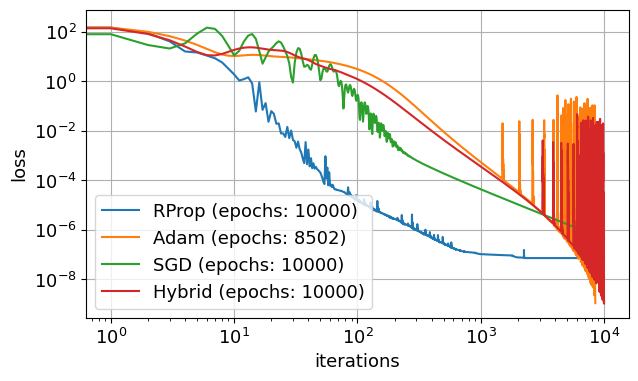

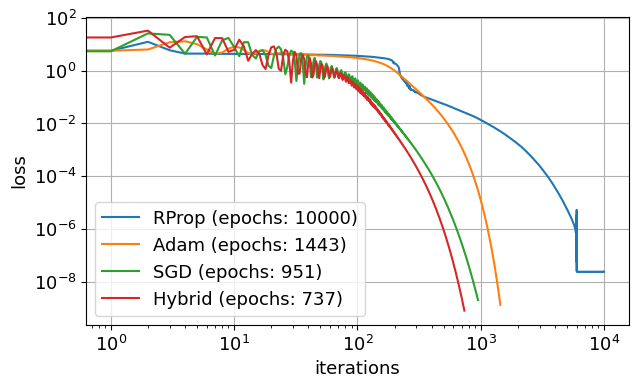

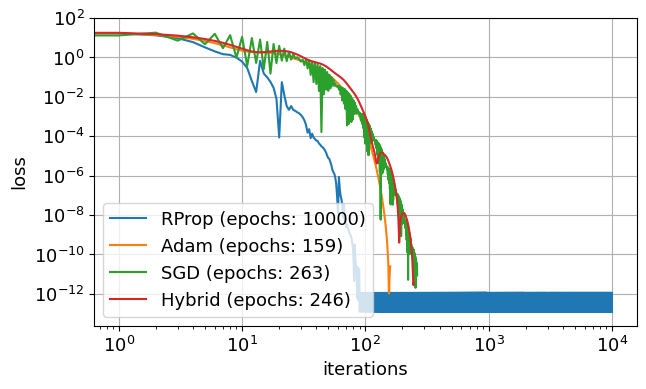

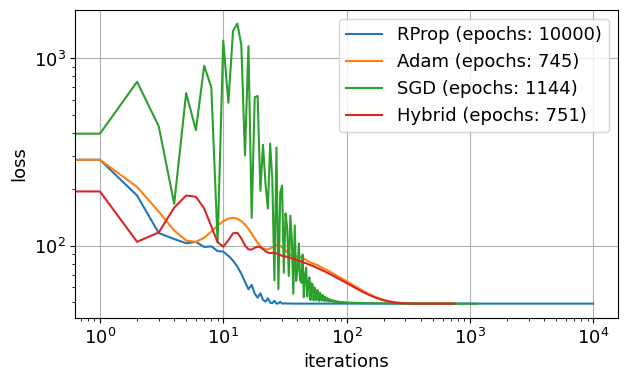

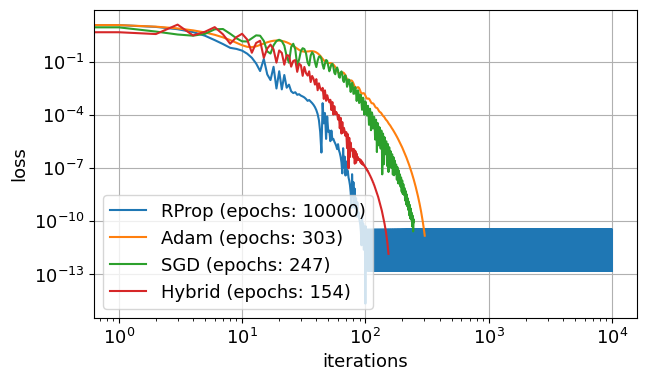

In [17]:
import numpy as np
import matplotlib.pyplot as plt
from typing import Callable, List, Tuple

# Loss landscapes
def powells_quartic(x: np.ndarray) -> float:
    return (x[0] + 10*x[1])**2 + 5*(x[2] - x[3])**2 + (x[1] - 2*x[2])**4 + 10*(x[0] - x[3])**4

def rosenbrock(x: np.ndarray) -> float:
    return sum(100.0*(x[1:] - x[:-1]**2.0)**2.0 + (1 - x[:-1])**2.0)

def quadratic(x: np.ndarray) -> float:
    return (x[0] + 2*x[1] - 7)**2 + (2*x[0] + x[1] - 5)**2

def freudenstein_roth(x: np.ndarray) -> float:
    return (x[0] - 13 + ((5 - x[1])*x[1] - 2)*x[1])**2 + (x[0] - 29 + ((x[1] + 1)*x[1] - 14)*x[1])**2

def beale(x: np.ndarray) -> float:
    return (1.5 - x[0] + x[0]*x[1])**2 + (2.25 - x[0] + x[0]*x[1]**2)**2 + (2.625 - x[0] + x[0]*x[1]**3)**2

# Gradients
def powells_quartic_gradient(x: np.ndarray) -> np.ndarray:
    grad = np.zeros_like(x)
    grad[0] = 2*(x[0] + 10*x[1]) + 40*(x[0] - x[3])**3
    grad[1] = 20*(x[0] + 10*x[1]) + 4*(x[1] - 2*x[2])**3
    grad[2] = 10*(x[2] - x[3]) - 8*(x[1] - 2*x[2])**3
    grad[3] = -10*(x[2] - x[3]) - 40*(x[0] - x[3])**3
    return grad

def rosenbrock_gradient(x: np.ndarray) -> np.ndarray:
    grad = np.zeros_like(x)
    grad[0] = -400*x[0]*(x[1] - x[0]**2) - 2*(1 - x[0])
    grad[1] += 200*(x[1] - x[0]**2)
    return grad

def quadratic_gradient(x: np.ndarray) -> np.ndarray:
    return np.array([
        10*x[0] + 8*x[1] - 34,
        8*x[0] + 10*x[1] - 38
    ])

def freudenstein_roth_gradient(x: np.ndarray) -> np.ndarray:
    grad = np.zeros_like(x)
    grad[0] = 2*(x[0] - 13 + ((5 - x[1])*x[1] - 2)*x[1]) + 2*(x[0] - 29 + ((x[1] + 1)*x[1] - 14)*x[1])
    grad[1] = 2*(x[0] - 13 + ((5 - x[1])*x[1] - 2)*x[1]) * ((5 - 2*x[1])*x[1] + (5 - x[1])*x[1] - 2) + \
              2*(x[0] - 29 + ((x[1] + 1)*x[1] - 14)*x[1]) * ((2*x[1] + 1)*x[1] + (x[1] + 1)*x[1] - 14)
    return grad

def beale_gradient(x: np.ndarray) -> np.ndarray:
    grad = np.zeros_like(x)
    grad[0] = 2*(1.5 - x[0] + x[0]*x[1])*(x[1] - 1) + \
              2*(2.25 - x[0] + x[0]*x[1]**2)*(x[1]**2 - 1) + \
              2*(2.625 - x[0] + x[0]*x[1]**3)*(x[1]**3 - 1)
    grad[1] = 2*(1.5 - x[0] + x[0]*x[1])*x[0] + \
              2*(2.25 - x[0] + x[0]*x[1]**2)*2*x[0]*x[1] + \
              2*(2.625 - x[0] + x[0]*x[1]**3)*3*x[0]*x[1]**2
    return grad

# Optimizers
class RProp:
    def __init__(self, eta_plus=1.2, eta_minus=0.5, delta_min=1e-6, delta_max=50.0):
        self.eta_plus = eta_plus
        self.eta_minus = eta_minus
        self.delta_min = delta_min
        self.delta_max = delta_max
        self.deltas = None
        self.prev_grads = None

    def initialize(self, dim):
        self.deltas = np.full(dim, 0.1)
        self.prev_grads = np.zeros(dim)

    def update(self, x, grad):
        if self.deltas is None:
            self.initialize(x.shape[0])

        grad_prod = grad * self.prev_grads
        self.deltas = np.where(grad_prod > 0, np.minimum(self.deltas * self.eta_plus, self.delta_max),
                               np.where(grad_prod < 0, np.maximum(self.deltas * self.eta_minus, self.delta_min),
                                        self.deltas))
        
        update = -np.sign(grad) * self.deltas
        grad = np.where(grad_prod < 0, 0, grad)
        self.prev_grads = grad
        
        return x + update

class Adam:
    def __init__(self, learning_rate=0.001, beta1=0.9, beta2=0.999, epsilon=1e-8):
        self.lr = learning_rate
        self.beta1 = beta1
        self.beta2 = beta2
        self.epsilon = epsilon
        self.m = None
        self.v = None
        self.t = 0

    def update(self, x, grad):
        if self.m is None:
            self.m = np.zeros_like(x)
            self.v = np.zeros_like(x)

        self.t += 1
        self.m = self.beta1 * self.m + (1 - self.beta1) * grad
        self.v = self.beta2 * self.v + (1 - self.beta2) * (grad ** 2)
        m_hat = self.m / (1 - self.beta1 ** self.t)
        v_hat = self.v / (1 - self.beta2 ** self.t)
        
        return x - self.lr * m_hat / (np.sqrt(v_hat) + self.epsilon)

class SGD:
    def __init__(self, learning_rate=0.01, momentum=0.9):
        self.lr = learning_rate
        self.momentum = momentum
        self.velocity = None

    def update(self, x, grad):
        if self.velocity is None:
            self.velocity = np.zeros_like(x)

        self.velocity = self.momentum * self.velocity - self.lr * grad
        return x + self.velocity

class Hybrid:
    def __init__(self, sgd_lr=0.01, adam_lr=0.001, gamma=0.5, momentum=0.9, beta1=0.9, beta2=0.999, epsilon=1e-8):
        self.sgd = SGD(learning_rate=sgd_lr, momentum=momentum)
        self.adam = Adam(learning_rate=adam_lr, beta1=beta1, beta2=beta2, epsilon=epsilon)
        self.gamma = gamma

    def update(self, x, grad):
        x_sgd = self.sgd.update(x.copy(), grad)
        x_adam = self.adam.update(x.copy(), grad)
        return self.gamma * x_adam + (1 - self.gamma) * x_sgd

def optimize(optimizer: Callable, obj_func: Callable, grad_func: Callable, 
             x0: np.ndarray, max_epochs: int, tol: float = 1e-6) -> Tuple[np.ndarray, List[float], int]:
    x = x0.copy()
    history = [obj_func(x)]
    for epoch in range(max_epochs):
        grad = grad_func(x)
        x_new = optimizer.update(x, grad)
        history.append(obj_func(x_new))
        if np.linalg.norm(x_new - x) < tol:
            return x_new, history, epoch + 1
        x = x_new
    return x, history, max_epochs

def grid_search(optimizer_class, param_grid: dict, obj_func: Callable, grad_func: Callable, 
                x0: np.ndarray, max_epochs: int) -> Tuple[dict, np.ndarray, List[float], int]:
    best_params = None
    best_x = None
    best_history = None
    best_epochs = None
    best_final_value = float('inf')

    for params in [dict(zip(param_grid.keys(), v)) for v in np.array(np.meshgrid(*param_grid.values())).T.reshape(-1, len(param_grid))]:
        optimizer = optimizer_class(**params)
        x, history, epochs = optimize(optimizer, obj_func, grad_func, x0, max_epochs)
        final_value = history[-1]
        
        if final_value < best_final_value:
            best_params = params
            best_x = x
            best_history = history
            best_epochs = epochs
            best_final_value = final_value

    return best_params, best_x, best_history, best_epochs

# Main execution
if __name__ == "__main__":
    landscapes = {
        "Powells Quartic": (powells_quartic, powells_quartic_gradient, np.array([3, -1, 0, 1])),
        "Rosenbrock": (rosenbrock, rosenbrock_gradient, np.array([-1.2, 1])),
        "Quadratic": (quadratic, quadratic_gradient, np.array([1, 1])),
        "Freudenstein and Roth": (freudenstein_roth, freudenstein_roth_gradient, np.array([0.5, -2])),
        "Beale": (beale, beale_gradient, np.array([1, 1]))
    }

    max_epochs = 10_000

    optimizers = {
        'RProp': (RProp, {'eta_plus': [1.1, 1.2, 1.3], 'eta_minus': [0.4, 0.5, 0.6]}),
        'Adam': (Adam, {'learning_rate': [0.001, 0.01, 0.1], 'beta1': [0.8, 0.9, 0.95]}),
        'SGD': (SGD, {'learning_rate': [0.001, 0.01, 0.1], 'momentum': [0.8, 0.9, 0.95]}),
        'Hybrid': (Hybrid, {
            'sgd_lr': [0.001, 0.01, 0.1],
            'adam_lr': [0.001, 0.01, 0.1],
            'gamma': [0.1, 0.3, 0.5, 0.7, 0.9],
            'momentum': [0.8, 0.9, 0.95]
        })
    }

    results_dict = {}

    for landscape_name, (obj_func, grad_func, x0) in landscapes.items():
        print(f"\nOptimizing {landscape_name} function:")
        results_dict[landscape_name] = {}
        sub_results_dict = {}

        for opt_name, (opt_class, param_grid) in optimizers.items():
            best_params, best_x, best_history, best_epochs = grid_search(
                opt_class, param_grid, obj_func, grad_func, x0, max_epochs
            )
            results_dict[landscape_name][opt_name] = {
                'best_params': best_params,
                'best_x': best_x.tolist(),
                'final_value': best_history[-1],
                'epochs': best_epochs,
                'best_history': best_history
            }
            print(f"{opt_name} - Best params: {best_params}, Final value: {best_history[-1]}, Epochs: {best_epochs}")


        # Plotting convergence speed
        plt.figure(figsize=(7, 4))
        for name, result in results_dict[landscape_name].items():
            plt.semilogx(result['best_history'], label=f"{name} (epochs: {result['epochs']})")
        plt.xlabel('iterations')
        plt.ylabel('loss')
        # plt.title(f"Convergence Speed of Optimizers on {landscape_name} Function")
        plt.legend()
        plt.yscale('log')
        plt.grid(True)
        plt.tight_layout
        plt.savefig(f'report/assets/optimizer_convergence__{landscape_name.replace(" ", "_").lower()}.png', dpi=200)
        # plt.close()





In [18]:
# Import required libraries
from texttable import Texttable
from latextable import draw_latex

# Create separate tables for each algorithm
for optimizer in set(opt for landscape in results_dict.values() for opt in landscape):
    table_data = []
    for landscape, optimizers in results_dict.items():
        if optimizer in optimizers:
            result = optimizers[optimizer]
            for param, value in result['best_params'].items():
                table_data.append([
                    landscape,
                    param,
                    f"${value}$"
                ])
            # table_data.append([
            #     landscape,
            #     "Final Value",
            #     f"{result['final_value']:.6f}"
            # ])

    # Create and populate the table
    table = Texttable()
    table.set_cols_align(["l", "l", "r"])
    table.set_cols_valign(["m", "m", "m"])
    table.add_rows([["Landscape", "Hyperparameter", "Value"]] + table_data)

    # Generate LaTeX code
    latex_table = draw_latex(
        table,
        caption=f"Optimization Results for {optimizer}",
        caption_above=True,        
    )

    # Print LaTeX code
    print(latex_table)
    print("\n")  # Add a newline between tables for readability


\begin{table}
	\caption{Optimization Results for Hybrid}
	\begin{center}
		\begin{tabular}{|l|l|r|}
			\hline
			Landscape & Hyperparameter & Value \\
			\hline
			Powells Quartic & sgd_lr & $0.001$ \\
			\hline
			Powells Quartic & adam_lr & $0.1$ \\
			\hline
			Powells Quartic & gamma & $0.9$ \\
			\hline
			Powells Quartic & momentum & $0.9$ \\
			\hline
			Rosenbrock & sgd_lr & $0.01$ \\
			\hline
			Rosenbrock & adam_lr & $0.1$ \\
			\hline
			Rosenbrock & gamma & $0.9$ \\
			\hline
			Rosenbrock & momentum & $0.95$ \\
			\hline
			Quadratic & sgd_lr & $0.001$ \\
			\hline
			Quadratic & adam_lr & $0.1$ \\
			\hline
			Quadratic & gamma & $0.7$ \\
			\hline
			Quadratic & momentum & $0.8$ \\
			\hline
			Freudenstein and Roth & sgd_lr & $0.001$ \\
			\hline
			Freudenstein and Roth & adam_lr & $0.1$ \\
			\hline
			Freudenstein and Roth & gamma & $0.9$ \\
			\hline
			Freudenstein and Roth & momentum & $0.8$ \\
			\hline
			Beale & sgd_lr & $0.1$ \\
			\hline
			Beale & adam_lr &

### Helper Functions

In [21]:
def generate_ml_run_name(word_length=3, num_words=2):
    """
    Generate a random short name for ML runs.
    
    Args:
    word_length (int): Length of each word in the name. Default is 3.
    num_words (int): Number of words in the name. Default is 2.
    
    Returns:
    str: A randomly generated name for an ML run.
    """
    consonants = 'bcdfghjklmnpqrstvwxyz'
    vowels = 'aeiou'
    
    def generate_word():
        word = ''
        for i in range(word_length):
            if i % 2 == 0:
                word += random.choice(consonants)
            else:
                word += random.choice(vowels)
        return word
    
    words = [generate_word() for _ in range(num_words)]
    return '_'.join(words)


def create_tf_dataset(X, y, batch_size=32, shuffle=True, prefetch=True):
    dataset = tf.data.Dataset.from_tensor_slices((X.values, y.values))
    
    if shuffle:
        dataset = dataset.shuffle(buffer_size=len(X))
    
    dataset = dataset.batch(batch_size)
    
    if prefetch:
        dataset = dataset.prefetch(tf.data.AUTOTUNE)
    
    return dataset



def get_metric(run_id: str, metric: str) -> np.ndarray:
    client = mlflow.tracking.MlflowClient()
    list_metric_hist = client.get_metric_history(run_id=run_id, key=metric)
    return np.array([
        m.value for m in list_metric_hist
    ])


class AveragingCallback(tf.keras.callbacks.Callback):
    def __init__(self, k_folds, metrics):
        super().__init__()
        self.k_folds = k_folds
        self.metrics = metrics + ['loss']
        self.current_fold = 0
        self.sum_metrics = {m: np.zeros(epochs) for m in self.metrics + [f'val_{m}' for m in self.metrics]}
        self.parent_run_id = None

    def set_parent_run_id(self, run_id):
        self.parent_run_id = run_id

    def on_train_begin(self, logs=None):
        self.current_fold += 1

    def on_epoch_end(self, epoch, logs=None):
        for metric in self.metrics:
            if len(self.sum_metrics[metric]) <= epoch:
                self.sum_metrics[metric].append(0)
                self.sum_metrics[f'val_{metric}'].append(0)
            
            self.sum_metrics[metric][epoch] += logs.get(metric, 0)
            self.sum_metrics[f'val_{metric}'][epoch] += logs.get(f'val_{metric}', 0)
        
        # Calculate and log running averages
        if self.current_fold == self.k_folds:
            for metric in self.metrics:
                avg_train = self.sum_metrics[metric][epoch] / self.k_folds
                avg_val = self.sum_metrics[f'val_{metric}'][epoch] / self.k_folds
                mlflow.log_metric(f"{metric}", avg_train, step=epoch, run_id=self.parent_run_id)
                mlflow.log_metric(f"val_{metric}", avg_val, step=epoch, run_id=self.parent_run_id)

    def on_train_end(self, logs=None):
        if self.current_fold == self.k_folds:
            # Log final averages
            for metric in self.metrics:
                final_avg_train = np.mean(self.sum_metrics[metric] / self.k_folds)
                final_avg_val = np.mean(self.sum_metrics[f'val_{metric}'] / self.k_folds)
                # mlflow.log_metric(f"final_avg_{metric}", final_avg_train, run_id=self.parent_run_id)
                mlflow.log_metric(f"validation_{metric}", final_avg_val, run_id=self.parent_run_id)

def average_metrics(metrics_list):
    return {k: np.mean([d[k] for d in metrics_list]) for k in metrics_list[0]}


### Plotting - Adam

Best run details:
Run ID: 1615b66f29364bf1addaf95f35259373
Accuracy: 0.9851
Learning Rate: 0.001
Momentum (beta_1): 0.05


/tmp/ipykernel_46379/4285050892.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  plot_data[[


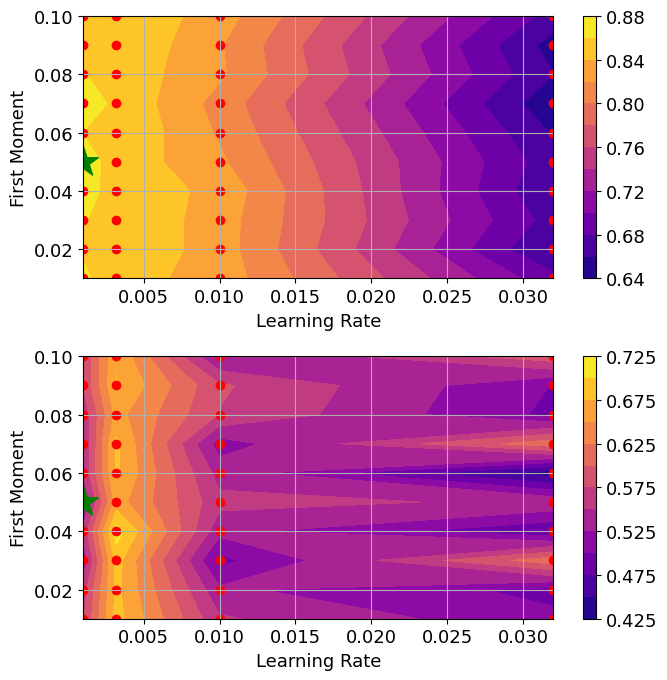

In [44]:
exp_name = 'cos711_ass_2__optimisers_study_v1'
metrics_of_interest = ['accuracy', "recall", "precision", 'val_accuracy', "val_recall", "val_precision", "loss", "val_loss"]


all_runs = mlflow.search_runs(experiment_names=[exp_name])
# filter only for adam optimizers
all_runs = all_runs[all_runs['params.optimiser'] == 'Adam'].dropna(how='all')




# filter out all subruns (keep only parent runs)
all_runs = all_runs[all_runs["tags.mlflow.parentRunId"].isnull()].dropna(how='all')
# Find the best run based on accuracy
best_run = all_runs.loc[all_runs['metrics.val_accuracy'].idxmax()]
best_run__lr = float(best_run['params.learning_rate'])
best_run__beta1 = float(best_run['params.momentum'])

print("Best run details:")
print(f"Run ID: {best_run['run_id']}")
print(f"Accuracy: {best_run['metrics.accuracy']:.4f}")
print(f"Learning Rate: {best_run['params.learning_rate']}")
print(f"Momentum (beta_1): {best_run['params.momentum']}")


# print(all_runs.columns.values)
plot_data = all_runs[[
    'run_id',
    'metrics.accuracy',
    'metrics.loss',
    'metrics.val_accuracy',
    'metrics.val_loss',
    'params.learning_rate',
    'params.momentum',  # beta_1
    'start_time',
    'end_time'
]]
plot_data[[
    'metrics.accuracy',
    'metrics.loss',
    'metrics.val_accuracy',
    'metrics.val_loss',
    'params.learning_rate',
    'params.momentum',  # beta_1
]] = plot_data[[
        'metrics.accuracy',
        'metrics.loss',
        'metrics.val_accuracy',
        'metrics.val_loss',
        'params.learning_rate',
        'params.momentum',  # beta_1
    ]].astype(float)


# Pivot the DataFrame
pivoted__acc = plot_data.pivot(index='params.momentum', columns='params.learning_rate', values='metrics.val_accuracy')
pivoted__los = plot_data.pivot(index='params.momentum', columns='params.learning_rate', values='metrics.val_loss')

# Create the contour plot
plt.figure(1, (7, 7), dpi=100)

plt.subplot(2, 1, 1)
contour = plt.contourf(pivoted__acc.columns, pivoted__acc.index, pivoted__acc.values, levels=12, cmap='plasma')
plt.scatter(plot_data['params.learning_rate'], plot_data['params.momentum'], c='r')
plt.scatter(best_run__lr, best_run__beta1, c='g', marker='*', s=500)
plt.grid()
plt.colorbar(contour)
plt.xlabel('Learning Rate')
plt.ylabel('First Moment')

plt.subplot(2, 1, 2)
contour = plt.contourf(pivoted__los.columns, pivoted__los.index, pivoted__los.values, levels=12, cmap='plasma')
plt.scatter(plot_data['params.learning_rate'], plot_data['params.momentum'], c='r')
plt.scatter(best_run__lr, best_run__beta1, c='g', marker='*', s=500)
plt.grid()
plt.colorbar(contour)
plt.xlabel('Learning Rate')
plt.ylabel('First Moment')

plt.tight_layout()
plt.savefig("report/assets/optimiser_grid__adam", dpi=200)
plt.show()




### Plotting - SGD

Best run details:
Run ID: 5b65d93c187a48aab50271dbb91a2983
Accuracy: 0.8289
Learning Rate: 0.032
Momentum: 0.09


/tmp/ipykernel_46379/1402918669.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  plot_data[[


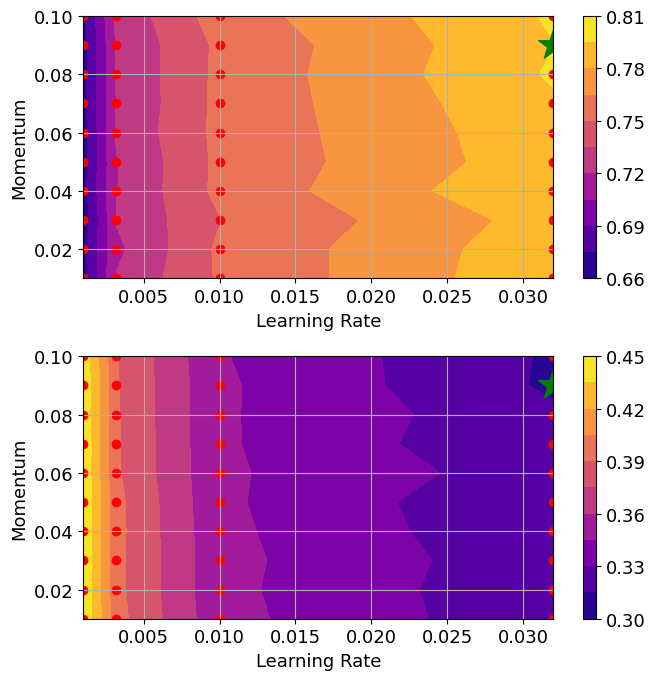

In [45]:
exp_name = 'cos711_ass_2__optimisers_study_v1'
metrics_of_interest = ['accuracy', "recall", "precision", 'val_accuracy', "val_recall", "val_precision", "loss", "val_loss"]


all_runs = mlflow.search_runs(experiment_names=[exp_name])
# filter only for adam optimizers
all_runs = all_runs[all_runs['params.optimiser'] == 'SGD'].dropna(how='all')
# Find the best run based on accuracy
best_run = all_runs.loc[all_runs['metrics.val_accuracy'].idxmax()]

print("Best run details:")
print(f"Run ID: {best_run['run_id']}")
print(f"Accuracy: {best_run['metrics.val_accuracy']:.4f}")
print(f"Learning Rate: {best_run['params.learning_rate']}")
print(f"Momentum: {best_run['params.momentum']}")

# Optionally, you can mark this point on the plot
best_lr = float(best_run['params.learning_rate'])
best_momentum = float(best_run['params.momentum'])

# filter out all subruns (keep only parent runs)
all_runs = all_runs[all_runs["tags.mlflow.parentRunId"].isnull()].dropna(how='all')


# print(all_runs.columns.values)
plot_data = all_runs[[
    'run_id',
    'metrics.accuracy',
    'metrics.loss',
    'metrics.val_accuracy',
    'metrics.val_loss',
    'params.learning_rate',
    'params.momentum',  # beta_1
    'start_time',
    'end_time'
]]
plot_data[[
    'metrics.accuracy',
    'metrics.loss',
    'metrics.val_accuracy',
    'metrics.val_loss',
    'params.learning_rate',
    'params.momentum',  # beta_1
]] = plot_data[[
        'metrics.accuracy',
        'metrics.loss',
        'metrics.val_accuracy',
        'metrics.val_loss',
        'params.learning_rate',
        'params.momentum',  # beta_1
    ]].astype(float)


# Pivot the DataFrame
pivoted__acc = plot_data.pivot(index='params.momentum', columns='params.learning_rate', values='metrics.val_accuracy')
pivoted__los = plot_data.pivot(index='params.momentum', columns='params.learning_rate', values='metrics.val_loss')

# Create the contour plot
plt.figure(1, (7, 7), dpi=100)

plt.subplot(2, 1, 1)
contour = plt.contourf(pivoted__acc.columns, pivoted__acc.index, pivoted__acc.values, levels=12, cmap='plasma')
plt.scatter(plot_data['params.learning_rate'], plot_data['params.momentum'], c='r')
plt.scatter(best_lr, best_momentum, c='g', marker='*', s=500)
plt.grid()
plt.colorbar(contour)
plt.xlabel('Learning Rate')
plt.ylabel('Momentum')

plt.subplot(2, 1, 2)
contour = plt.contourf(pivoted__los.columns, pivoted__los.index, pivoted__los.values, levels=12, cmap='plasma')
plt.scatter(plot_data['params.learning_rate'], plot_data['params.momentum'], c='r')
plt.scatter(best_lr, best_momentum, c='g', marker='*', s=500)
plt.grid()
plt.colorbar(contour)
plt.xlabel('Learning Rate')
plt.ylabel('Momentum')

plt.tight_layout()
plt.savefig("report/assets/optimiser_grid__sgd", dpi=200)
plt.show()
